# Analyzing Social Interactions Among Drug Users in Hartford with the `NETWORK` Actionset And `OPTMODEL`

In this demonstration, we load edge data representing needle-sharing interactions between drug users in Hartford, Connecticut. We then use our CAS server to examine the graph and derive insights that could be used for public health interventions.

Note that this notebook is derived from the example found here: [A Simple Pipeline using Hypergroup to Perform Community Detection and Network Analysis](https://github.com/sassoftware/sas-viya-programming/blob/master/python/network-analysis/Hartford%20Drug%20User%20Social%20Network%20Analysis%20using%20CAS%20HyperGroup.ipynb). The major difference between these examples is that this notebook utilizes actions from the `NETWORK` actionset, while the referenced notebook utilizes actions from the `HYPERGROUP` actionset. 

The dataset we utilize in this notebook is used by permission from Margaret R. Weeks at the Institute of Community Resesarch (http://www.incommunityresearch.org). The study associated with it is described in this paper: [Social Networks of Drug Users in High-Risk Sites: Finding the Connections](https://www.researchgate.net/publication/227085871_Social_Networks_of_Drug_Users_in_High-Risk_Sites_Finding_the_Connections).

On first examination of the dataset, we see that the data itself appears of limited use. The CSV is a simple edge list with two columns (`FROM` and `TO`). The nodes are only represented as numbers. The network is directed, and ties represent the lending of drug needles.

However, using the tools available in the `NETWORK` actionset, we can begin to assess the most influential members of the network. Such information is crucial for community health practitioners. Helping these users limit risky behaviors can have a bigger impact on the broader network than intervening with random users.

----------------
We demonstrate three approaches to determine which users in the network are the best candidates to train as peer educators, based on the size of their reach (ego) networks. In the paper, the stated coverage goal of the overall network was half of the primary connected component. Since the overall component contains n = 193 nodes, we want to reach n = 97 nodes through the ego networks of the peer educators we choose to target.

The three techniques we demonstrate are:
1. Replicate the results of the referenced paper. In this method, the authors rely on degree centrality (both total as well as out degree centrality. They choose the top nodes that return a total reach of 97.

2. Refine the approach in (1) by the following method:
    1. Calculate overall degree centrality
    2. Perform community detection and determine the optimal number of communities
    3. Within each community, calculate the cumulative density function for the distribution of degree centrality
    4. Nodes that score above a defined CDF threshold are nominated as peer educator candidates.
    5. Determine the total coverage of these nodes by calculating the reach networks of each node.
    
3. Calculate all possible reach networks, then use `PROC OPTMODEL` to determine which nodes can reach the desired market coverage.


We compare the effectiveness of these measures by examining the nodes selected as peer educators, as well as the number of unique nodes that are potentially reached by the peer educators.

----------------

The basic flow of this notebook is as follows:
1. Connect to our CAS server and load the actionsets we require.
2. Use the remote connection capabilities of SWAT to grab the data csv and upload it to our CAS server.
3. Review the dataset and make an initial network plot to visualize any connections.
4. Calculate degree centrality for each node in the network. We choose degree centrality because it is a simple measure that shows the count of interactions between nodes.
5. Calculate community detection and identify the best subdivision of groups in the network.
6. Using the information provided by the centrality and community measures, identify the specific nodes to target for intervention.
7. Show which nodes can be reached in two hops by the nodes identified in the previous step.
    
----------------
__Prepared by:__
Damian Herrick (<i class="fa fa-github" aria-hidden="true"></i>: [dtherrick](www.github.com/dtherrick))

## Imports

Our imports are broken out as follows:

| Module               | Method         | Description                                                                                |
|:---------------------|:--------------:|:------------------------------------------------------------------------------------------:|
| `os`                 | all            | Allows access to environment variables.                                                    |
| `sys`                | all            | Used to update our system path so Python can import our custom utility functions.          |
| `pathlib`            | Path           | Used for directory and file management.                                                    |
| `swat`               | all            | SAS Python module that orchestrates communication with a CAS server.                       |
| `pandas`             | all            | Data management module we use for preparation of local data.                               |
| `itertools`          | all            | Use `chain` method to flatten lists of lists.                                              |
| `math`               | ceil           | `ceil` method needed for rounding up when we determine node coverage in Method C.          |
| `collections`        | Counter        | Used in conjunction with the dataclass when calculating summaries for each method.         |
| `dataclasses`        | make_dataclass | Used to create a custom data structure that stores the individule results for each method. |
| `typing`             | List           | Used in the custom data structure to store the list of nodes we use.                       |
| `numpy`              | all            | Used in multiple locations for various utility needs.                                      |
| `networkx`           | all            | Need graph structure, layouts, and drawing capabilities.                                   |
| `seaborn`            | all            | Currently only used to despine (remove frames) from each network plot.                     |
| `matplotlib.pyplot`  | all            | Used for generating the main figures.                                                      |
| `matplotlib.colors`  | all            | Used to generate custom (SAS-themed) colormaps.                                            |
| `matplotlib.cm`      | all            | Used in generating the legends for each figure.                                            |
| `matplotlib.patches` | Ellipse        | Used to create annotations when needed.                                                    |


In [1]:
import os
import sys
import itertools
from pathlib import Path
from math import ceil
from collections import Counter
from dataclasses import make_dataclass
from typing import List

import swat
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.patches import Ellipse
import seaborn as sns

%matplotlib inline

## Initialization and Setup

### Set the path variables for our images and main directories

In [2]:
current_dir = Path.cwd()

images_parts = list(current_dir.parts)
images_parts[-1] = 'images'
images_dir = Path(*images_parts)

### Define our colormaps to align to SAS colors

Since we're using the matplotlib plotting engine here, we can leverage its custom colormap functionality.

We define the colors as RGB values provided in the SAS PowerPoint template, then convert them to hex and create a `ListedColormap` for each of them.

In [3]:
SAS_MAIN_RGB = [[51, 163, 255], [42, 209, 209], [21, 181, 173], [148, 113, 255], [134, 19, 79],  [255, 204, 50]]
SAS_OPTIONAL_RGB = [[211, 64, 70],  [252, 109, 29], [252, 82, 175], [13, 197, 194], [8, 36, 58]]
SAS_TEXT_RGB = [[1, 32, 54], [118, 131, 150],  [255, 255, 255]]

SAS_MAIN_HEX = colors.ListedColormap([colors.to_hex(list(map(lambda x:x/255 ,group))) for group in SAS_MAIN_RGB])
SAS_OPTIONAL_HEX = colors.ListedColormap([colors.to_hex(list(map(lambda x:x/255 ,group))) for group in SAS_OPTIONAL_RGB])
SAS_TEXT_HEX = colors.ListedColormap([colors.to_hex(list(map(lambda x:x/255 ,group))) for group in SAS_TEXT_RGB])

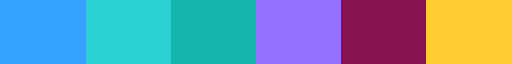

In [4]:
SAS_MAIN_HEX

In [5]:
SAS_MAIN_HEX_ALPHA = SAS_MAIN_HEX(np.arange(SAS_MAIN_HEX.N))
#SAS_MAIN_HEX_ALPHA[:, -1] = np.linspace(1, 0, SAS_MAIN_HEX.N)
SAS_MAIN_HEX_ALPHA[:, -1] = 0.5
SAS_MAIN_HEX_ALPHA = colors.ListedColormap(SAS_MAIN_HEX_ALPHA)

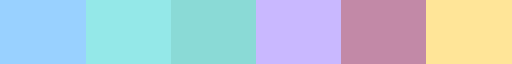

In [6]:
SAS_MAIN_HEX_ALPHA

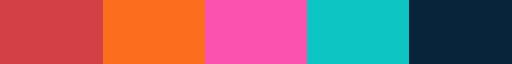

In [7]:
SAS_OPTIONAL_HEX

In [8]:
SAS_OPTIONAL_HEX_ALPHA = SAS_OPTIONAL_HEX(np.arange(SAS_OPTIONAL_HEX.N))
SAS_OPTIONAL_HEX_ALPHA[:, -1] = np.linspace(1, 0, SAS_OPTIONAL_HEX.N)
SAS_OPTIONAL_HEX_ALPHA = colors.ListedColormap(SAS_OPTIONAL_HEX_ALPHA)

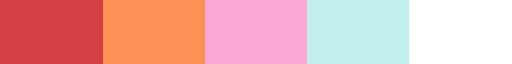

In [9]:
SAS_OPTIONAL_HEX_ALPHA

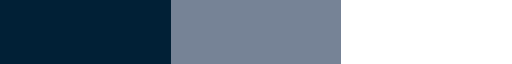

In [10]:
SAS_TEXT_HEX

### Make the dataclass that will hold our results summary object after we finish each method.
At the end we combine all three results into a dataframe to determine which method works best

In [11]:
resultSummary = make_dataclass("resultSummary", [('allNodes', int), ('educators', int), ('reached', int), ('unreached', int), ('educatorIDs', List)])

### Connect to CAS, load the actionsets we'll need, and upload our graph to the CAS server.

In [12]:
host = os.environ['CAS_HOST_ORGRD']
port = int(os.environ['CAS_PORT'])


conn = swat.CAS(host, port)

conn.loadactionset("network")
conn.loadactionset('datastep')
conn.loadactionset('fedsql')
conn.loadactionset('datapreprocess')
conn.loadactionset('optimization')

NOTE: Added action set 'network'.
NOTE: Added action set 'datastep'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'datapreprocess'.
NOTE: Added action set 'optimization'.


[actionset]

 'optimization'

+ Elapsed: 0.00661s, user: 0.00748s, sys: 0.0138s, mem: 1.42mb

In [13]:
url = 'https://raw.githubusercontent.com/sassoftware/sas-viya-programming/master/python/network-analysis/drug_network.csv'

out = conn.upload(url, 
                  importoptions=dict(vars=[dict(type='varchar'), dict(type='varchar')]))

# initialize our local graph reference (avoid throwing an error in the next cell).
src_graph = None

NOTE: Cloud Analytic Services made the uploaded file available as table DRUG_NETWORK in caslib CASUSERHDFS(daherr).
NOTE: The table DRUG_NETWORK has been created in caslib CASUSERHDFS(daherr) from binary data uploaded to Cloud Analytic Services.


### Examine a few values in the dataset and verify that it is a simple edge list

In [14]:
conn.fetch('drug_network', to=10)

,FROM,TO
0,1,2
1,1,9
2,1,10
3,2,9
4,2,10
5,2,111
6,3,7
7,3,166
8,3,175
9,4,7


Our edge list is a set of [`FROM`,`TO`] pairs, identified as numbers. We know nothing else about the characteristics of each node. (Note that the referenced paper does provide a significant amount of additional demographic and drug use information).

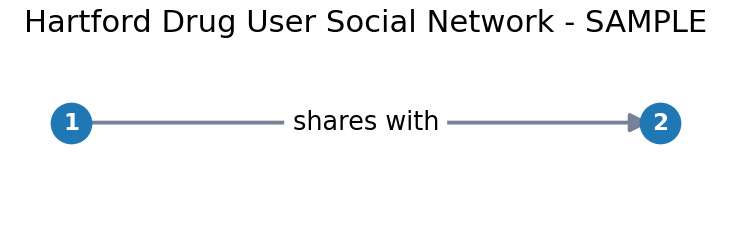

In [15]:
title = "Hartford Drug User Social Network - SAMPLE"


G_sample = nx.DiGraph()
G_sample.add_edge(1, 2, label="shares with")

pos_sample = nx.nx_agraph.graphviz_layout(G_sample,  prog='sfdp', root=1, args='-Grankdir="LR"')   # 'neato', ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’

plt.figure(figsize=(10,3), dpi=92)
plt.title(title, fontsize=24, y=0.9)

label_dict_sample = {k:k for k in dict(G_sample.nodes).keys()}


nx.draw_networkx_nodes(G_sample, pos_sample, node_size=1000, cmap=SAS_MAIN_HEX)
nx.draw_networkx_labels(G_sample, pos_sample, labels=label_dict_sample, font_color=SAS_TEXT_HEX.colors[-1], font_weight="bold", font_size=18)
nx.draw_networkx_edges(G_sample, pos_sample, width=3, edge_color=SAS_TEXT_HEX.colors[1], arrowsize=30)

nx.draw_networkx_edge_labels(G_sample,
                             pos_sample,
                             edge_labels=nx.get_edge_attributes(G_sample,'label'),
                            font_size=20)

plt.axis("off")
plt.savefig(images_dir / 'sample_relationship.png')
plt.show()

### Load a graph using the `loadgraph` action

In [16]:
if src_graph is not None:
    conn.network.unloadgraph(graph=src_graph.graph)
    
src_graph = conn.network.loadgraph(links="drug_network",
                                   direction='directed')

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.


Our plotting method requires a node list in addition to an edge list.

We don't have a simple node list as an input to the graph we load, but we will return node tables with several of the network actions we call. Initially, though, we'll get our nodes table by outputting one by running the `summary` action.

We can also use this to collect some basic information about our graph.

In [17]:
result = conn.network.summary(graph=src_graph.graph,
                              direction='directed',
                              connectedcomponents=True,
                              out={'name':'outSummary', 'replace':True},
                              outnodes={'name':'nodesInitial', 'replace':True}
                             )

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing summary metrics.
NOTE: Processing summary metrics used 0.00 (cpu: 0.00) seconds.


Let's review the summary statistics to see what we can learn about the network.

In [18]:
conn.fetch('outSummary')

,nodes,links,avg_links_per_node,density,self_links_ignored,dup_links_ignored,leaf_nodes,singleton_nodes,concomp,isolated_pairs,isolated_stars_out,isolated_stars_in
0,193.0,273.0,1.414508,0.007367,0.0,0.0,80.0,0.0,193.0,0.0,0.0,0.0


#### What do the summary statistics tell us?
* We confirm we have 193 nodes, and 273 links among them.
* The average node only has a little more than one link to another node; this low average is also reflected in the extremely low density.
* 80 nodes are leaf nodes.
* There are no isolated pairs - all nodes in the graph are connected to all other nodes.

#### Plot the graph
* We don't know much about the graph properties but hopefully we can begin to see some additional information from a plot.
* All of this happens locally - not on the CAS server - so we start by making an edgelist dataframe pulled from our `drug_network` table on the CAS server.
* We then create a networkx graph from the edgelist.
* Finally, create our single positions dictionary. We'll rely on this through the remainder of the notebook to insure consistency of our layouts for each figure.

In [19]:
df_links = pd.DataFrame(conn.CASTable("drug_network").to_frame())

G = nx.from_pandas_edgelist(df_links, source="FROM", target="TO", create_using=nx.DiGraph)

pos = nx.nx_pydot.graphviz_layout(G, prog="neato")   # 'neato', ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’

Before we plot the graph, estimate two communities. We're choosing two communities because we're familiar with the figures in the reference paper, and there appear to be two weakly connected communities. We need these communities so that we can cross-reference nodes by community into the notebooks, find the center and extents of the nodes, and use that to generate the ellipses. 

This process involves:
1. Put the position dictionary into a dataframe, where the node is the index, and there are two columns `x` and `y`.
1. Calculate communities.
2. Get the nodes BY community.
3. Select nodes in each community in the `df_pos` dataframe, and then get the center: (x_mean, y_mean) and extents: (x_max, y_max), (x_min, y_min) for each community.

Following these steps allows us to properly place our ellipses.

In [20]:
result = conn.network.community(graph=src_graph.graph,
                                resolutionlist=[0.1],
                                outnodes={'name': 'nodesCommTwoOnly', 'replace': True},
                                )

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing community detection using 1 threads across 1 machines.
NOTE: At resolution=0.1, the community algorithm found 2 communities with modularity=0.466047.
NOTE: Processing community detection used 0.00 (cpu: 0.00) seconds.


In [21]:
df_pos = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
dfNodesCommTwo = pd.DataFrame(conn.CASTable('nodesCommTwoOnly').to_frame())
comm1 = dfNodesCommTwo[dfNodesCommTwo['community_0'] == 0.0]['node'].to_list()
comm2 = dfNodesCommTwo[dfNodesCommTwo['community_0'] == 1.0]['node'].to_list()

x_mean1, y_mean1 = df_pos[df_pos.index.isin(comm1)].describe()['x']['mean'], df_pos[df_pos.index.isin(comm1)].describe()['y']['mean']
x_mean2, y_mean2 = df_pos[df_pos.index.isin(comm2)].describe()['x']['mean'], df_pos[df_pos.index.isin(comm2)].describe()['y']['mean']

x_min1, y_min1 = df_pos[df_pos.index.isin(comm1)].describe()['x']['min'], df_pos[df_pos.index.isin(comm1)].describe()['y']['min']
x_min2, y_min2 = df_pos[df_pos.index.isin(comm2)].describe()['x']['min'], df_pos[df_pos.index.isin(comm2)].describe()['y']['min']

x_max1, y_max1 = df_pos[df_pos.index.isin(comm1)].describe()['x']['max'], df_pos[df_pos.index.isin(comm1)].describe()['y']['max']
x_max2, y_max2 = df_pos[df_pos.index.isin(comm2)].describe()['x']['max'], df_pos[df_pos.index.isin(comm2)].describe()['y']['max']

In [22]:
print(f"<---- Community 1 ---->")
print(f"Mean 1: {x_mean1, y_mean1}")
print(f" Min 1: {x_min1, y_min1}")
print(f" Max 1: {x_max1, y_max1}\n")

print(f"<---- Community 2 ---->")
print(f"Mean 2: {x_mean2, y_mean2}")
print(f" Min 2: {x_min2, y_min2}")
print(f" Max 2: {x_max2, y_max2}")

<---- Community 1 ---->
Mean 1: (555.5257899159662, 834.5317647058823)
 Min 1: (27.0, 450.82)
 Max 1: (929.29, 1361.5)

<---- Community 2 ---->
Mean 2: (1066.5221621621622, 545.050027027027)
 Min 2: (826.59, 18.0)
 Max 2: (1483.7, 949.74)


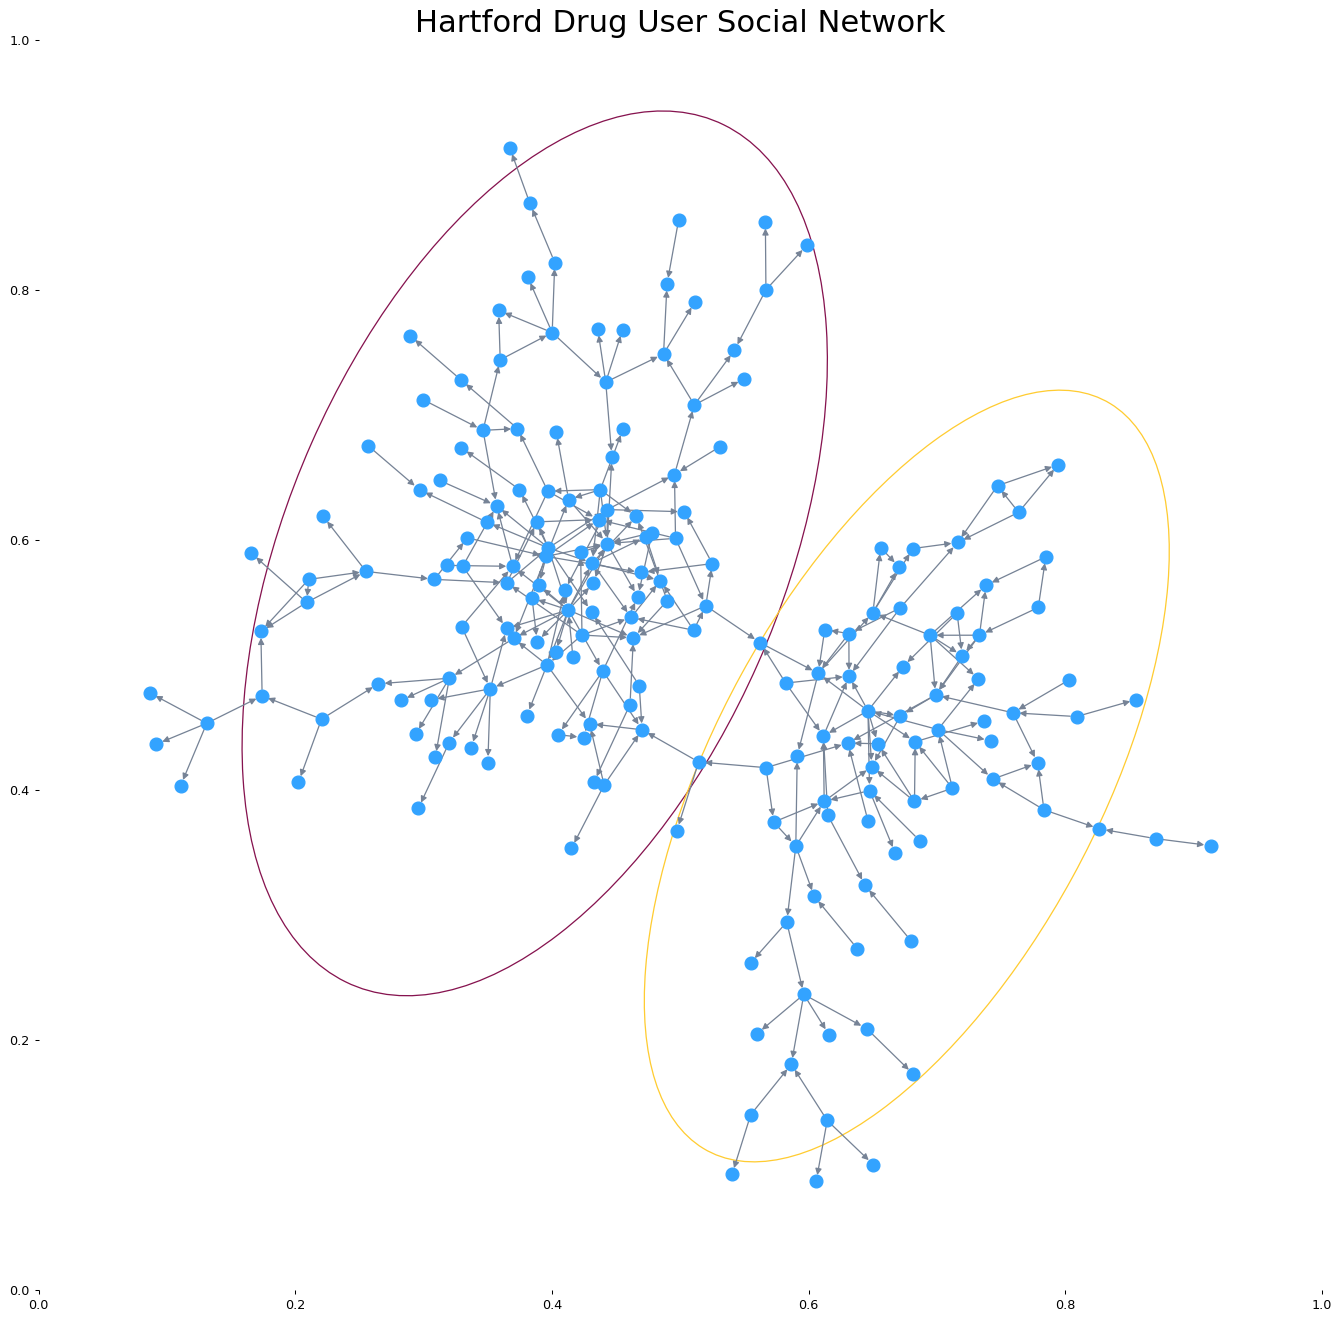

In [23]:
title = "Hartford Drug User Social Network"

plt.figure(figsize=(18,18), dpi=92)

plt.title(title, fontsize=24)

# Create the ellipse patches.
# note the hard-coded scaling constants for the width and height of each ellipse. Generated through trial and error (as is the rotation angle).
e1 = Ellipse((x_mean1, y_mean1), (x_max1 - x_min1) * 0.75, (y_max1 - y_min1) * 1.35, angle=-25.0, edgecolor=SAS_MAIN_HEX.colors[-2], fill=False)
e2 = Ellipse((x_mean2, y_mean2), (x_max2 - x_min2) * 0.8, (y_max2 - y_min2) * 1.2, angle=-30.0, edgecolor=SAS_MAIN_HEX.colors[-1], fill=False)

f = plt.figure(1)

ax = f.add_subplot(1,1,1)
ax.add_artist(e1)
ax.add_artist(e2)

sns.axes_style({'xtick.bottom':False, 'ytick.left':False, 'xtick.color':'white', 'ytick.color':'white'})

nx.draw(G, pos, node_size=100, node_color=SAS_MAIN_HEX.colors[0], edge_color=SAS_TEXT_HEX.colors[1])


sns.despine(left=True, bottom=True)
plt.savefig(images_dir / 'initial_network.png')
plt.show()

### What does this tell us?
* The one connected component can be thought of as two weakly connected components, highlighted by the two ellipses.
* Outside of this, there isn't much more to understand. Which makes sense - we don't know much more about the additional attributes of this graph (node or edge).

## Method A: Degree Centrality Influence

As noted above, we first calculate degree centrality for all nodes in the network, we then rearrange the resulting output tables to sort by total degree centrality, followed by out-degree centrality.

We then verify the results by calculating the reach (ego) networks for the nodes identified in the centrality estimate.

In [24]:
result = conn.network.centrality(graph=src_graph.graph,
                                 direction = 'directed',
                                 degree='unweight',
                                 outnodes={
                                     'name': "nodesCentrA", 'replace': True
                                 }
                                )

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.


In [25]:
conn.fetch(table={'name':'nodesCentrA'}, 
           sortby=[
               {'name':'centr_degree', 
                'order':'descending'},
               {'name':'centr_degree_out', 
                'order':'descending'}],
          to=20)

,node,centr_degree_in,centr_degree_out,centr_degree
0,43,2.0,13.0,15.0
1,27,1.0,10.0,11.0
2,52,8.0,3.0,11.0
3,34,1.0,9.0,10.0
4,46,2.0,5.0,7.0
5,53,2.0,5.0,7.0
6,49,3.0,4.0,7.0
7,19,0.0,6.0,6.0
8,115,1.0,5.0,6.0
9,21,1.0,5.0,6.0


In [26]:
conn.datastep.runcode(code=f"""data nodeSubsetInA ;
                                set nodesCentrA;
                                where centr_degree >= 5.0;
                                keep node centr_degree_out;
                                run;
                            """
                      )

conn.datastep.runcode(code=f"""data nodeSubsetInA (replace=yes);
                                set nodeSubsetInA;
                                retain reach;
                                where centr_degree_out >= 4.0;
                                reach = _N_;
                                keep node reach;
                                run;
                            """
                      )

[InputCasTables]

                 casLib           Name  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  nodeSubsetInA    19        2  CASTable('nodeSubsetInA', caslib='CASUSERHDFS(...

[OutputCasTables]

                 casLib           Name  Rows  Columns  Append Promoted                                           casTable
 0  CASUSERHDFS(daherr)  nodeSubsetInA    19        2     NaN        N  CASTable('nodeSubsetInA', caslib='CASUSERHDFS(...

+ Elapsed: 0.0271s, user: 0.0863s, sys: 0.0901s, mem: 54.3mb

In [27]:
conn.fetch('nodeSubsetInA')

,node,reach
0,113,1.0
1,115,2.0
2,17,3.0
3,19,4.0
4,21,5.0
5,27,6.0
6,28,7.0
7,33,8.0
8,34,9.0
9,42,10.0


In [28]:
conn.network.reach(links         = {"name":"drug_network"},
                   direction     = 'undirected',
                   nodessubset   = {"name":"nodeSubSetInA"},
                   outReachNodes = {"name":"ReachNodesA",  "replace":True},
                   outReachLinks = {"name":"ReachLinksA",  "replace":True},
                   outCounts     = {"name":"ReachCountsA", "replace":True},
                   maxreach      = 2)

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing reach networks using 80 threads across 5 machines.
NOTE: Processing reach networks for 19 source networks.
NOTE: Processing reach networks used 0.00 (cpu: 0.00) seconds.


[OutputCasTables]

                 casLib          Name Label  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)   ReachLinksA         602        3  CASTable('ReachLinksA', caslib='CASUSERHDFS(da...
 1  CASUSERHDFS(daherr)   ReachNodesA         442        2  CASTable('ReachNodesA', caslib='CASUSERHDFS(da...
 2  CASUSERHDFS(daherr)  ReachCountsA          19        4  CASTable('ReachCountsA', caslib='CASUSERHDFS(d...

[ProblemSummary]

 Problem Summary
 
             Name1           Label1       cValue1  nValue1
 0        numNodes  Number of Nodes           193    193.0
 1        numLinks  Number of Links           273    273.0
 2  graphDirection  Graph Direction    Undirected      NaN

[SolutionSummary]

 Solution Summary
 
          Name1           Label1       cValue1   nValue1
 0  problemType     Problem Type         Reach       NaN
 1       status  Solution Status            OK       NaN
 2      cpuTime         CPU Time          0.00  0.000000
 3     realTime        Real Time          0.00  0.002596

[solutionStatus]

 'OK'

[solutionStatusCode]

 0

+ Elapsed: 0.0587s, user: 0.0705s, sys: 0.122s, mem: 557mb

In [29]:
conn.fetch('reachCountsA', to=35, sortby=[{'name':'count', 'order':'descending'}])

,reach,node,count,count_not
0,11.0,43,51.0,142.0
1,6.0,27,40.0,153.0
2,13.0,49,34.0,159.0
3,12.0,46,34.0,159.0
4,9.0,34,31.0,162.0
5,10.0,42,29.0,164.0
6,4.0,19,25.0,168.0
7,15.0,56,25.0,168.0
8,5.0,21,23.0,170.0
9,3.0,17,22.0,171.0


In [30]:
dfReachLinksA = pd.DataFrame(conn.CASTable('reachLinksA').to_frame())

dfReachCountsA = pd.DataFrame(conn.CASTable('reachCountsA').to_frame())

reach_setA = dfReachCountsA['reach'].to_list()

source_setA = dfReachCountsA['node'].to_list()

sink_set_1A = [dfReachLinksA[(dfReachLinksA['reach'] == x) & (~dfReachLinksA['TO'].isin(dfReachLinksA[dfReachLinksA['reach'] == x]['FROM']))]['TO'].to_list() for x in reach_setA]
sink_setA = list(set(list(itertools.chain(*sink_set_1A))))

included_nodesA = list(set(dfReachLinksA['FROM'].to_list() + dfReachLinksA['TO'].to_list()))

intermediate_nodesA = set(included_nodesA).difference(set(source_setA)).difference(set(sink_setA))

#### Prepare the plots

In [31]:
source_nodes_dictA = {x:3 for x in source_setA}
inter_nodes_dictA = {x:2 for x in intermediate_nodesA}
terminal_nodes_dictA = {x:1 for x in sink_setA}

reach_network_catA = {**terminal_nodes_dictA, **inter_nodes_dictA, **source_nodes_dictA}
reach_network_nodesA = list(reach_network_catA.keys())

all_nodes = list(G.nodes())
unreached_nodesA = list(set(all_nodes).difference(set(reach_network_nodesA)))
unreached_nodes_dictA = {x: 0 for x in unreached_nodesA}

full_network_catA = {**reach_network_catA, **unreached_nodes_dictA}

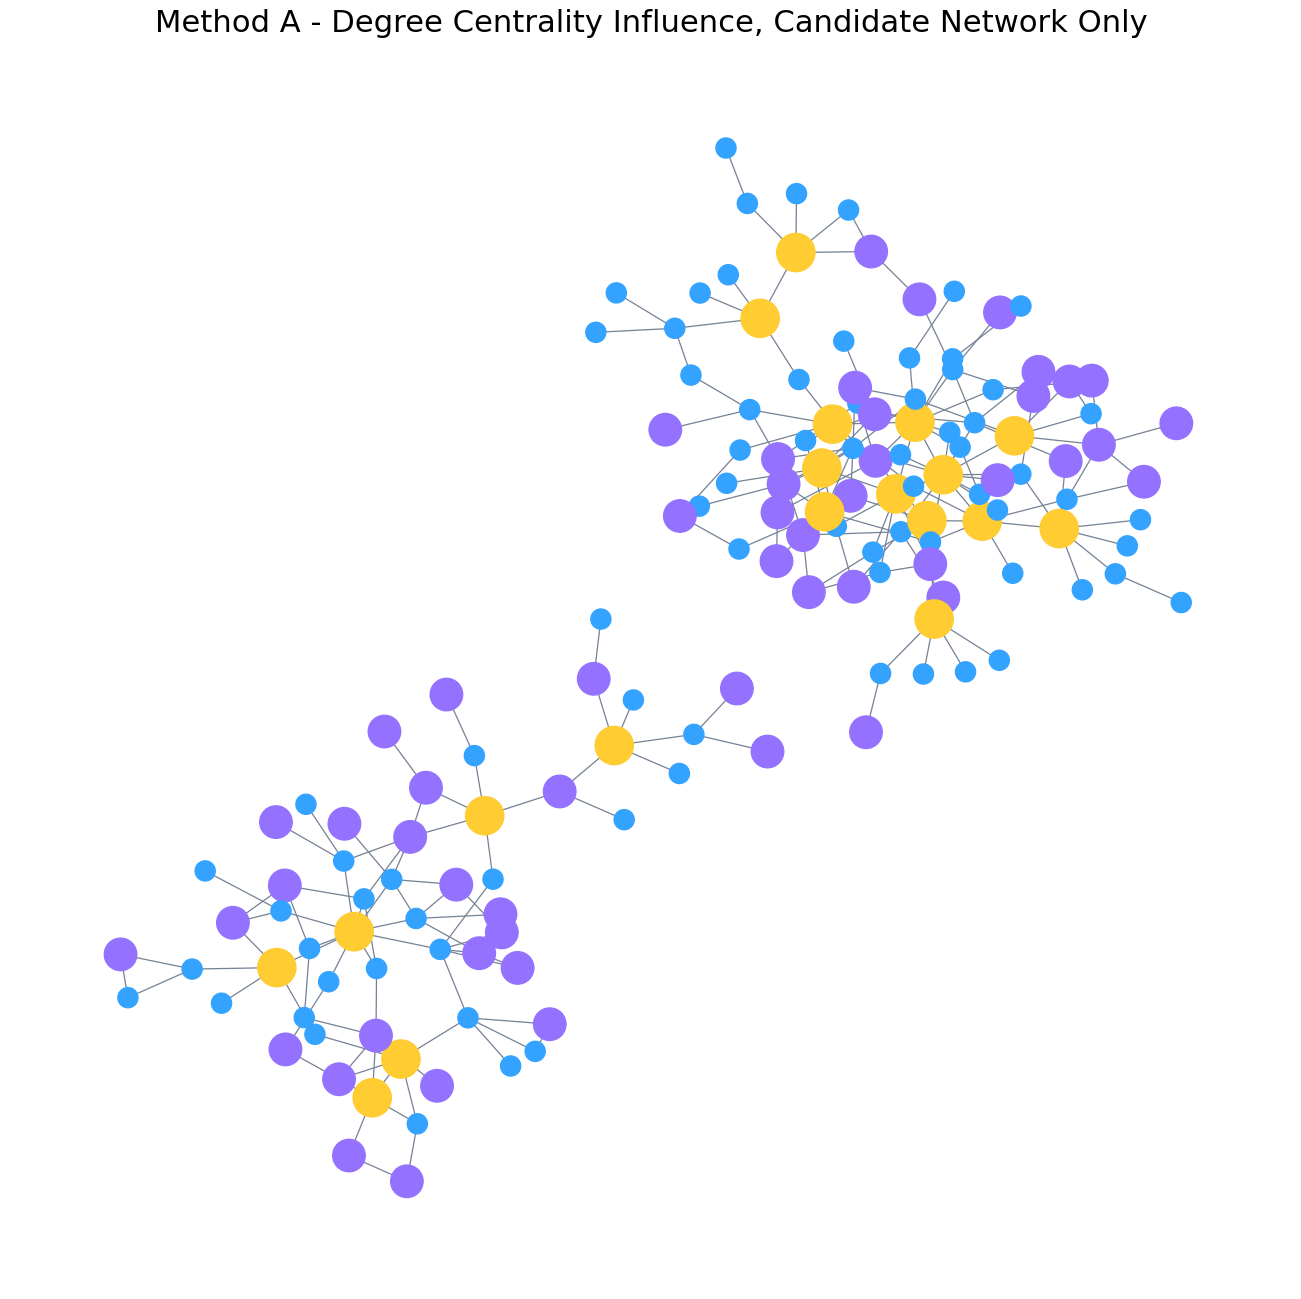

In [32]:
title = "Method A - Degree Centrality Influence, Candidate Network Only"


G1 = nx.from_pandas_edgelist(dfReachLinksA, source="FROM", target="TO", create_using=nx.Graph)

pos1 = nx.nx_pydot.graphviz_layout(G1, prog="neato")   # 'neato', ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’

df_reach_node_infoA1 = pd.DataFrame.from_dict(reach_network_catA, orient='index', columns=["category"])
df_reach_node_infoA1['size'] = np.where(df_reach_node_infoA1['category']==3, 900, 
                                        np.where(df_reach_node_infoA1['category']==2, 650, 
                                                 np.where(df_reach_node_infoA1['category']== 1, 250, 50)
                                                         )
                                                )

df_reach_node_infoA1.reset_index(inplace=True)
df_reach_node_infoA1 = df_reach_node_infoA1.rename(columns = {'index':'node'})

df_reach_node_infoA1['label'] = np.where(df_reach_node_infoA1['category']>= 1, df_reach_node_infoA1['node'], '')

df_reach_node_infoA1.set_index('node', inplace=True)

# cmap = colors.ListedColormap([SAS_MAIN_HEX.colors[0], SAS_MAIN_HEX.colors[2], SAS_MAIN_HEX.colors[-2], SAS_MAIN_HEX.colors[-1]])

nx.set_node_attributes(G1, df_reach_node_infoA1.to_dict(orient='index'))
color_listA1 = list(nx.get_node_attributes(G1, 'category').values())
size_listA1 = list(nx.get_node_attributes(G1, 'size').values())
label_dictA1 = nx.get_node_attributes(G1, 'label')

plt.figure(figsize=(18,18), dpi=92)

plt.title(title, fontsize=24)

nx.draw(G1, 
        pos1, 
        node_size=size_listA1, 
        node_color=color_listA1, 
        cmap=SAS_MAIN_HEX, 
        edge_color=SAS_TEXT_HEX.colors[1], 
#        labels=label_dictA1, 
        font_color=SAS_TEXT_HEX.colors[-1],
        font_size=9
       )

plt.show()

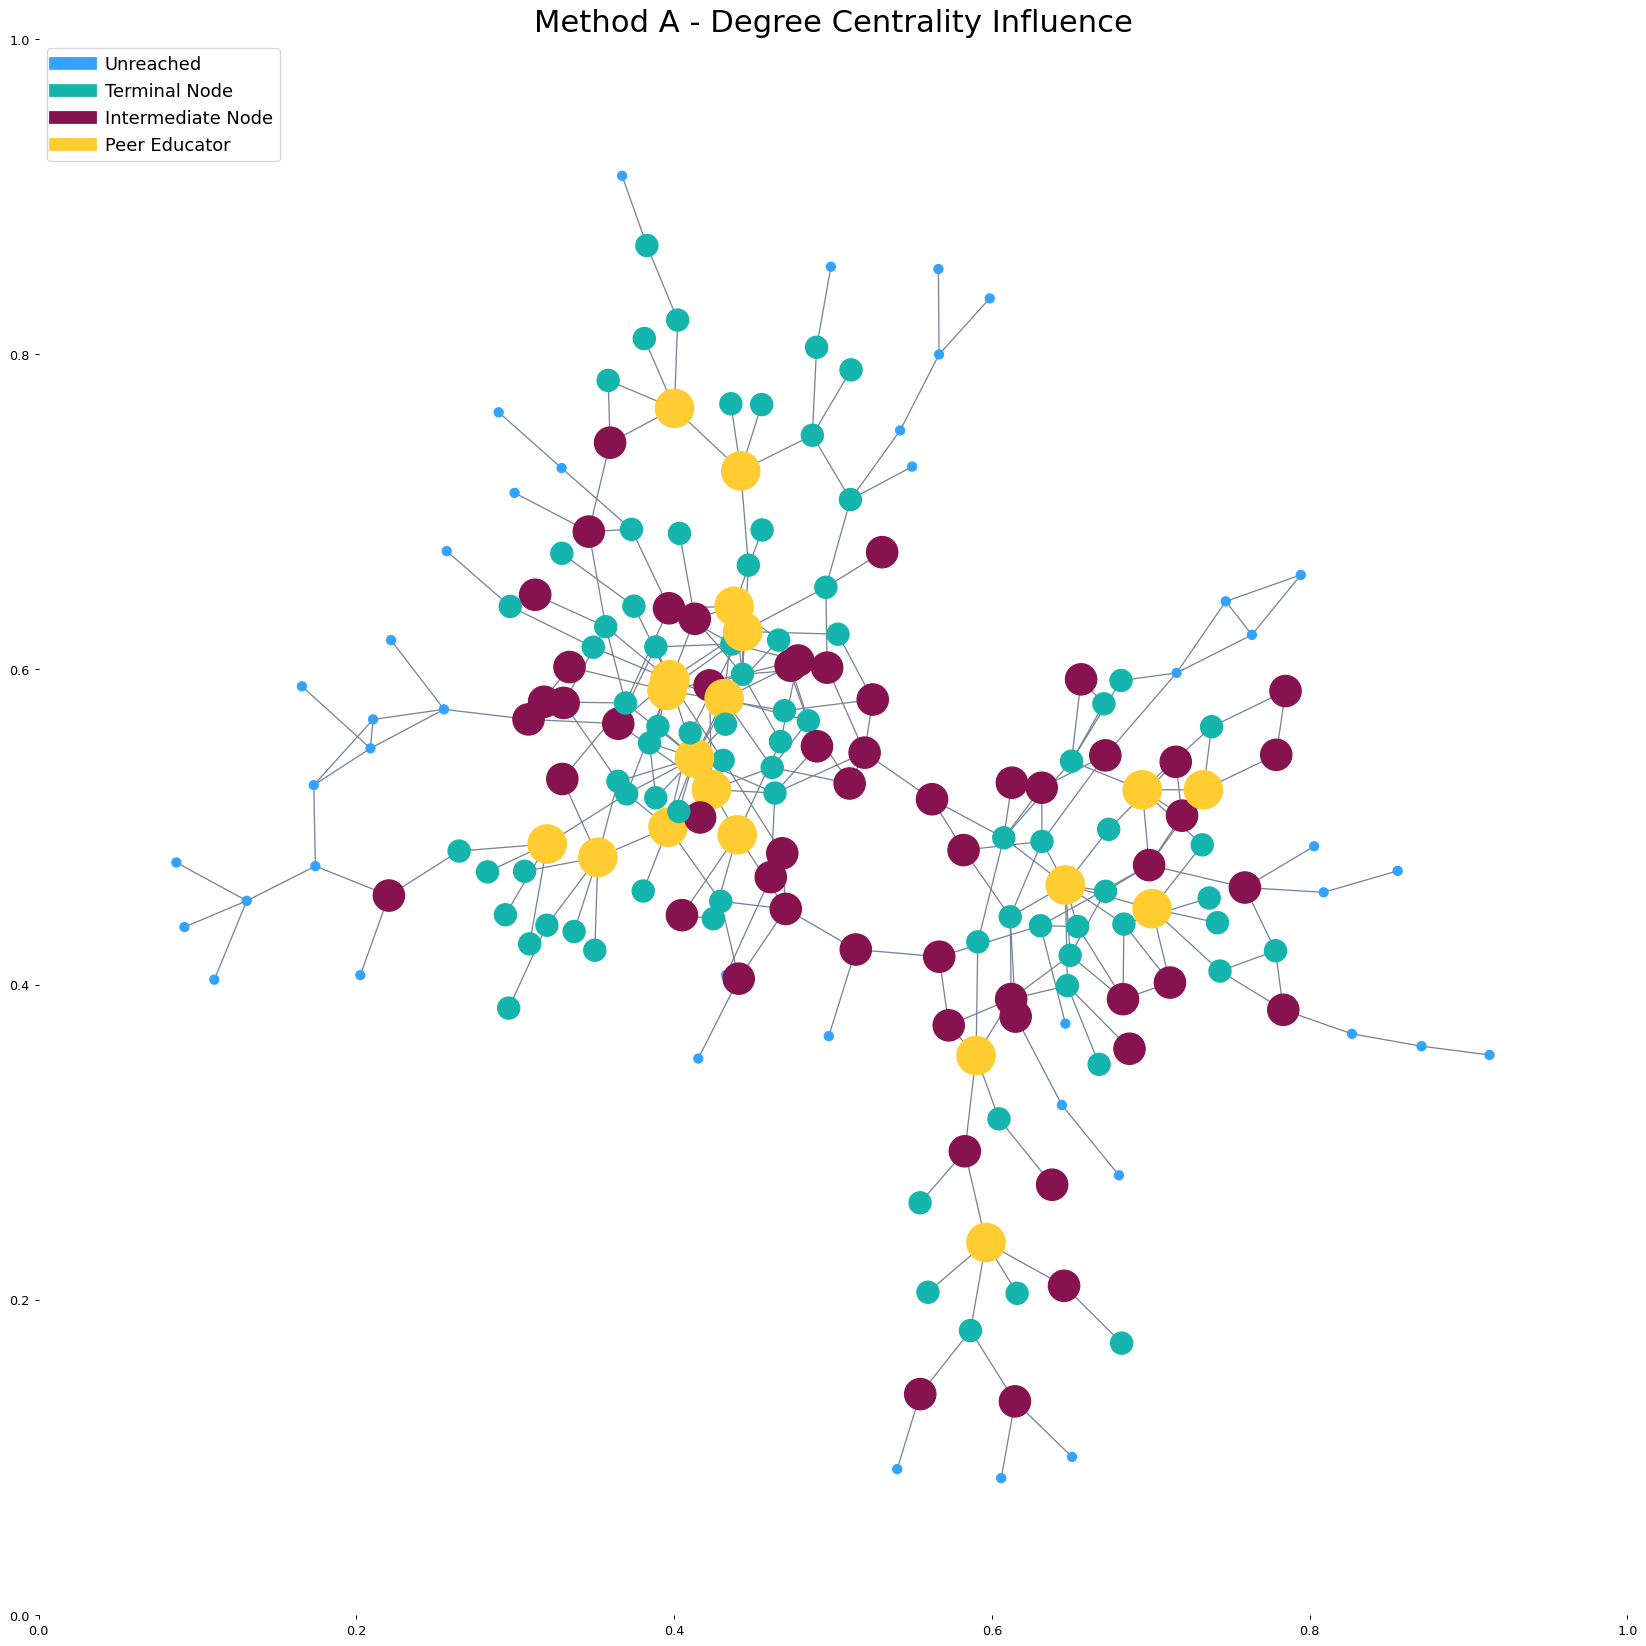

In [33]:
title = "Method A - Degree Centrality Influence"

G_A = nx.from_pandas_edgelist(df_links, source="FROM", target="TO", create_using=nx.Graph)

df_node_infoA = pd.DataFrame.from_dict(full_network_catA, orient='index', columns=["category"])
df_node_infoA['size'] = np.where(df_node_infoA['category']==3, 900, np.where(df_node_infoA['category']==2, 600, np.where(df_node_infoA['category']== 1, 300, 50)))

df_node_infoA.reset_index(inplace=True)
df_node_infoA = df_node_infoA.rename(columns = {'index':'node'})

df_node_infoA['label'] = np.where(df_node_infoA['category']>= 1, df_node_infoA['node'], '')

df_node_infoA['title'] = np.where(df_node_infoA['category']==3, 'Peer Educator',  
                                          np.where(df_node_infoA['category']== 2, 'Intermediate Node', 
                                                   np.where(df_node_infoA['category']==1, 'Terminal Node', 
                                                            'Unreached'
                                                           )
                                                  )
                                         )

df_node_infoA.set_index('node', inplace=True)

nx.set_node_attributes(G_A, df_node_infoA.to_dict(orient='index'))
color_listA = list(nx.get_node_attributes(G_A, 'category').values())
size_listA = list(nx.get_node_attributes(G_A, 'size').values())
label_dictA = nx.get_node_attributes(G_A, 'label')
title_listA = list(nx.get_node_attributes(G_A, 'title').values())

plt.figure(figsize=(18,18), dpi=92)

plt.title(title, fontsize=24)

node_colorA = dict(zip(all_nodes, color_listA))
legend = list(set(color_listA))
title_dictA = dict(zip(color_listA, title_listA))

get_node_colorA = [node_colorA[v] for v in G_A]
cNormA = colors.Normalize(vmin=min(get_node_colorA), vmax=max(get_node_colorA))
scalarMapA = cmx.ScalarMappable(norm=cNormA, cmap=SAS_MAIN_HEX)

f = plt.figure(1)

ax = f.add_subplot(1,1,1)
for item in legend:
    ax.plot(
        [0],
        [0],
        color=scalarMapA.to_rgba(item),
        label=title_dictA[item],
        linewidth=10
    )
    

plt.legend(loc="upper left", prop={'size': 14})

nx.draw(G_A, 
        pos, 
        node_size=size_listA, 
        node_color=color_listA, 
        cmap=SAS_MAIN_HEX, 
        edge_color=SAS_TEXT_HEX.colors[1], 
#        labels=label_dictA, 
        font_color=SAS_TEXT_HEX.colors[-1],
        font_size=9
       )

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig(images_dir / 'method_a.png')
plt.show()

In [34]:
methodA_titleCounts = dict(Counter(title_listA))

resultsA = resultSummary(allNodes=len(all_nodes), 
                         educators=methodA_titleCounts['Peer Educator'], 
                         reached=len(all_nodes) - methodA_titleCounts['Peer Educator'] - methodA_titleCounts['Unreached'],
                         unreached=methodA_titleCounts['Unreached'],
                         educatorIDs=list(conn.CASTable('nodesubsetinA').to_dict()['node'].values())
                        )

In [35]:
resultsA

resultSummary(allNodes=193, educators=19, reached=132, unreached=42, educatorIDs=['113', '115', '17', '19', '21', '27', '28', '33', '34', '42', '43', '46', '49', '53', '56', '61', '69', '77', '90'])

## Method B: Degree Centrality Within Community Influence

### Overview

* In this method, we first determine the optimal number of communities (mostly via review of number of members in each community, as well as modularity).
* Then find the degree centrality in each community.
* From there, by community, assign a z-score and then any nodes with a z-score above 0.85 is a peer educator candidate.
* Finally calculate two-hop reach networks as in Method A, then plot.

### Examine the communities in the graph.

* We use the Louvain method, and provide four resolutions. Lower resolution value finds fewer communities with more nodes, while higher values find more communities, with fewer nodes per community.
* Optimum community counts is somewhat subjective - we use our intuition and the graph plot to identify the correct number of communities.

In [36]:
result = conn.network.community(graph=src_graph.graph,
                                resolutionlist=[0.25, 0.5,1.0,1.5],
                                outlinks={'name': 'linksComm', 'replace': True},
                                outnodes={'name': 'nodesComm', 'replace': True},
                                outcommlinks={'name': 'linksCommL', 'replace': True},
                                outcommunity={'name': 'outComm', 'replace': True},
                                outlevel={'name': 'outCommLevel', 'replace': True},
                                outoverlap={'name':'outCommOverlap', 'replace': True}
                                )

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing community detection using 1 threads across 1 machines.
NOTE: At resolution=1.5, the community algorithm found 16 communities with modularity=0.721934.
NOTE: At resolution=1, the community algorithm found 12 communities with modularity=0.726710.
NOTE: At resolution=0.5, the community algorithm found 7 communities with modularity=0.674570.
NOTE: At resolution=0.25, the community algorithm found 5 communities with modularity=0.630251.
NOTE: Processing community detection used 0.00 (cpu: 0.00) seconds.


* For our purposes, we determine that resolution = 0.5, and its seven communities, is the appropriate number for our data.
* We want to see which nodes have connections outside their assigned community. We can use the `outCommOverlap` table to determine this from the `intensity` column.
    * Intensity is defined as the number of intra-community links from/to a node by the total links. If a node has only intra-community links, the intensity will be 1.0. Any value less than 1.0 means that the node connects to at least one other community.

In [37]:
conn.fetch(table={'name':'outCommOverlap', 'where':'intensity < 1.0'}, sortby=[{'name':'intensity', 'order':'descending'}])

,node,community,intensity
0,90,1.0,0.750000
1,52,1.0,0.666667
2,26,4.0,0.666667
3,54,1.0,0.666667
4,66,1.0,0.666667
5,44,1.0,0.500000
6,29,3.0,0.500000
7,15,0.0,0.500000
8,29,2.0,0.500000
9,15,1.0,0.500000


In [38]:
conn.fetch('nodesComm', to=100)

,node,community_0,community_1,community_2,community_3
0,1,0.0,0.0,0.0,0.0
1,10,0.0,0.0,0.0,0.0
2,100,1.0,1.0,1.0,1.0
3,101,2.0,2.0,2.0,2.0
4,102,3.0,3.0,2.0,2.0
...,...,...,...,...,...
95,185,0.0,0.0,0.0,0.0
96,186,11.0,9.0,5.0,4.0
97,187,6.0,6.0,4.0,3.0
98,188,10.0,8.0,5.0,4.0


In [39]:
result = conn.network.centrality(links={'name': 'linksComm', 
                                        'groupby': [{'name':'community_3'}], 
                                        'where':'community_3 ne .'},
                                 degree='unweight',
                                 outnodes={
                                     'name': "nodesCentr", 'replace': True
                                 }
                                )

NOTE: The number of nodes in the input graph is 16.
NOTE: The number of links in the input graph is 17.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.
NOTE: The number of nodes in the input graph is 75.
NOTE: The number of links in the input graph is 115.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.
NOTE: The number of nodes in the input graph is 65.
NOTE: The number of links in the input graph is 95.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.
NOTE: The number of nodes in the input graph is 11.
NOTE: The number of links in the input graph is 10.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.
NOTE: The number of nodes in the input graph is 26.
NOTE: The number of links in the input graph is 26.
NOTE: Processing centrality metrics.
NOTE: Processing centralit

Let's review the communities. 
* From the note above we see that our resolutions provide a range of communities from 7 to 16 total.
* If we review the `outComm` table we see how many nodes are assigned to each community.

In [40]:
conn.fetch('nodesCentr')

,community_3,node,centr_degree_out
0,3.0,105,3.0
1,3.0,117,3.0
2,3.0,119,1.0
3,3.0,81,2.0
4,3.0,133,1.0
5,3.0,6,2.0
6,3.0,187,1.0
7,3.0,69,4.0
8,3.0,73,1.0
9,3.0,79,1.0


### Let's look at the distribution of centrality by community and find the most important nodes

1. Create a new table (we call nodesMerged but since we did groupby in the centrality action, this is a relic. Instead we keep it because it's used later on).
2. Get summary statistics for centrality in each community.
3. Merge the summary stats back into the nodes table.
4. For each centrality, calculate the deviation from its community mean.
5. generate the CDF and identify the nodes above the 0.9 threshold. Those are the important nodes we'll use in the reach analytic.

In [41]:
# Set up the data for our next step

conn.datastep.runcode(
   code="""data nodesMerged (rename=(community_3=community));
           set nodescentr;
           retain centr_degree 0 ColName "centr_degree_out";
           format ColName $CHAR15.;
           keep node centr_degree_out community_3 ColName;
           run;""")

[InputCasTables]

                 casLib        Name  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  nodescentr   193        3  CASTable('nodescentr', caslib='CASUSERHDFS(dah...

[OutputCasTables]

                 casLib         Name  Rows  Columns  Append Promoted                                           casTable
 0  CASUSERHDFS(daherr)  nodesMerged   193        4     NaN        N  CASTable('nodesMerged', caslib='CASUSERHDFS(da...

+ Elapsed: 0.0266s, user: 0.0758s, sys: 0.105s, mem: 54.8mb

#### Plot the Communities
* use the nodesMerged table

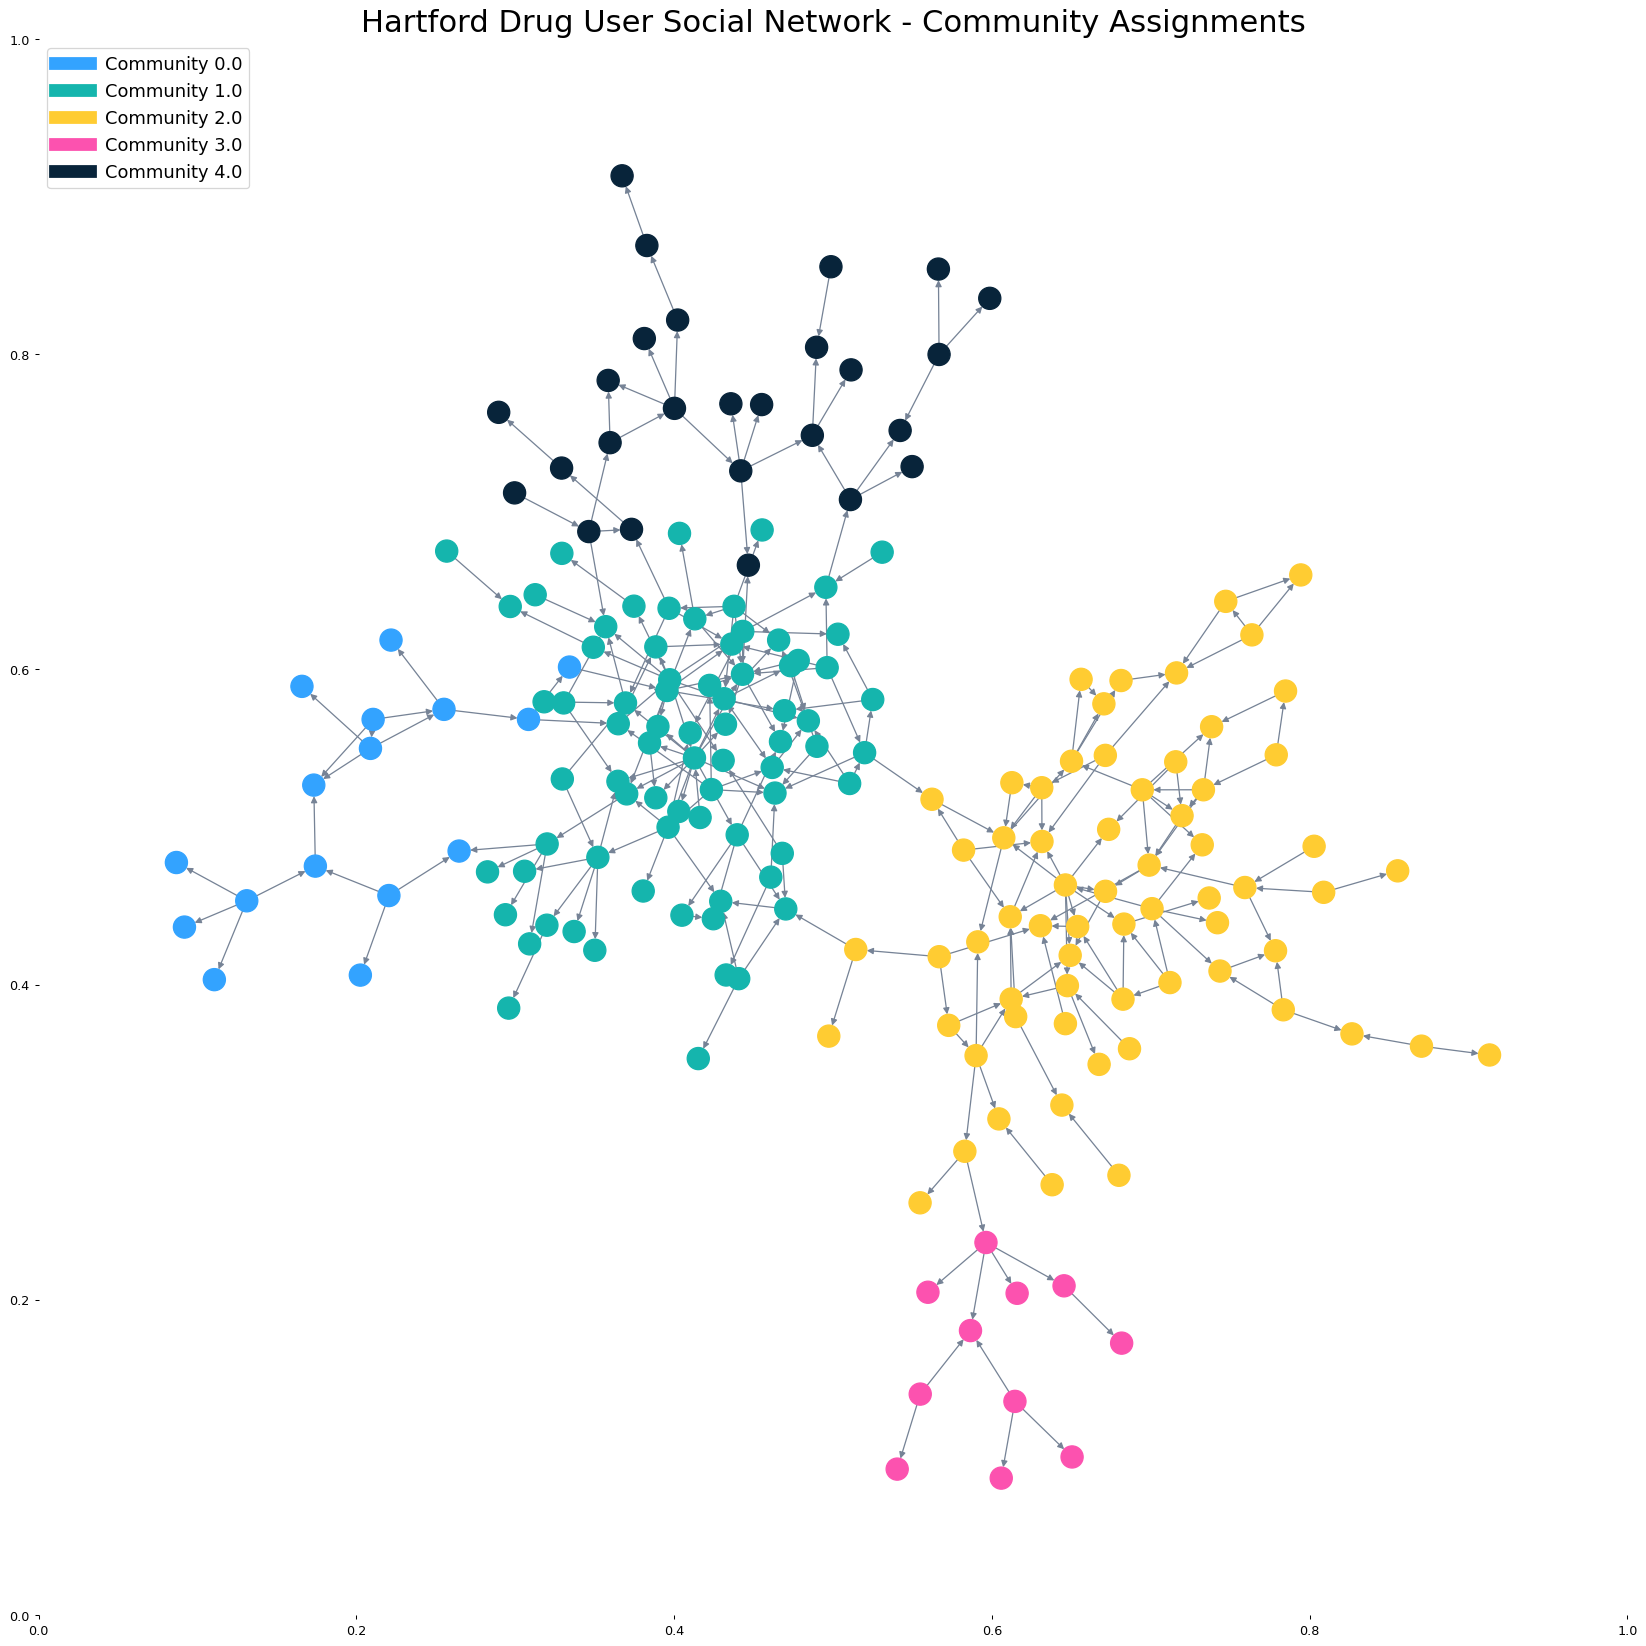

In [42]:
title = "Hartford Drug User Social Network - Community Assignments"

G_comm = nx.from_pandas_edgelist(df_links, source="FROM", target="TO", create_using=nx.DiGraph)

df_node_comm = pd.DataFrame(conn.CASTable('nodesmerged').to_frame())


df_node_comm['title'] = df_node_comm.apply(lambda x: 'Community ' + str(x['community']), axis=1)

df_node_comm.set_index('node', inplace=True)

nx.set_node_attributes(G_comm, df_node_comm.to_dict(orient='index'))
color_listComm = list(nx.get_node_attributes(G_comm, 'community').values())
title_listComm = list(nx.get_node_attributes(G_comm, 'title').values())

plt.figure(figsize=(18,18), dpi=92)

plt.title(title, fontsize=24)

cmap = colors.ListedColormap(list(SAS_MAIN_HEX.colors) + list(SAS_OPTIONAL_HEX.colors))

node_colorComm = dict(zip(all_nodes, color_listComm))
legend = list(set(color_listComm))
title_dictComm = dict(zip(color_listComm, title_listComm))

get_node_colorComm = [node_colorComm[v] for v in G_comm]
cNormComm = colors.Normalize(vmin=min(get_node_colorComm), vmax=max(get_node_colorComm))
scalarMapComm = cmx.ScalarMappable(norm=cNormComm, cmap=cmap)

f = plt.figure(1)

ax = f.add_subplot(1,1,1)
for item in legend:
    ax.plot(
        [0],
        [0],
        color=scalarMapComm.to_rgba(item),
        label=title_dictComm[item],
        linewidth=10
    )
    

plt.legend(loc="upper left", prop={'size': 14})

nx.draw(G_comm, 
        pos, 
        node_color=color_listComm, 
        cmap=cmap, 
        edge_color=SAS_TEXT_HEX.colors[1],  
        font_color=SAS_TEXT_HEX.colors[-1],
        font_size=9
       )

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig(images_dir / 'method_b_community.png')
plt.show()


In [43]:
# get summary statistics
conn.simple.summary(table={"name":"nodesMerged", 
                           "groupby":"community"},
                    inputs="centr_degree_out",
                    casout={"name":f"nodesMerged_summary", 
                            "replace":True}
                   )

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(daherr),nodesMerged_summary,5,19,"CASTable('nodesMerged_summary', caslib='CASUSE..."


In [44]:
conn.datastep.runcode(code=f"""data nodesMerged_stripped (keep=community ColName cmpMin cmpMax cmpCount cmpMean cmpSum);
                                set nodesMerged_summary;
                                format _Column_ $CHAR15.;
                                rename _Column_=ColName _Min_=cmpMin _Max_=cmpMax _NObs_=cmpCount _Mean_=cmpMean _Sum_=cmpSum;
                                run;
                            """
                     )

[InputCasTables]

                 casLib                 Name  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  nodesMerged_summary     5       19  CASTable('nodesMerged_summary', caslib='CASUSE...

[OutputCasTables]

                 casLib                  Name  Rows  Columns  Append Promoted                                           casTable
 0  CASUSERHDFS(daherr)  nodesMerged_stripped     5        7     NaN        N  CASTable('nodesMerged_stripped', caslib='CASUS...

+ Elapsed: 0.0281s, user: 0.102s, sys: 0.105s, mem: 54.2mb

In [45]:
conn.datastep.runcode(code=f"""data nodesMerged_int;
                                merge nodesMerged nodesMerged_stripped;
                                by community;
                                keep node centr_degree_out community cmpMin cmpMax cmpCount cmpMean cmpSum;
                                run;
                            """
                     )

[InputCasTables]

                 casLib                  Name  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)           nodesMerged   193        4  CASTable('nodesMerged', caslib='CASUSERHDFS(da...
 1  CASUSERHDFS(daherr)  nodesMerged_stripped     5        7  CASTable('nodesMerged_stripped', caslib='CASUS...

[OutputCasTables]

                 casLib             Name  Rows  Columns  Append Promoted                                           casTable
 0  CASUSERHDFS(daherr)  nodesMerged_int   193        8     NaN        N  CASTable('nodesMerged_int', caslib='CASUSERHDF...

+ Elapsed: 0.0518s, user: 0.123s, sys: 0.227s, mem: 54.2mb

In [46]:
# calculate the deviations
conn.datapreprocess.transform(table={"name": "nodesMerged_int", 
                                     "groupby":"community"}, 
                              copyvars=["node", "centr_degree_out", "cmpMin", "cmpMean", "cmpMax", "cmpCount", "cmpSum"],
                              requestpackages=[{"inputs": "centr_degree_out",
                                                "function": {"method": "standardize",
                                                             "arguments": {"location": "mean", 
                                                                           "scale": "std"
                                                                          }
                                                            }
                                                }],
                              casout={"name":"nodesMerged_dev", 
                                      "replace":True}
                             )

[ByGroup1.TransInfo]

 Transformation Requests for NODESMERGED_INT
 
           ActualName  NTransVars         Func FunctArgs
 community                                              
 0               _TR1           1  Standardize  Mean Std

[ByGroup1.VarTransInfo]

 Variable Transformation Information for NODESMERGED_INT
 
                    Variable Transformation              ResultVar   N  NMiss  FuncArgVals1  FuncArgVals2
 community                                                                                               
 0          centr_degree_out           _TR1  _TR1_centr_degree_out  16      0         2.125      1.258306

[ByGroup2.TransInfo]

 Transformation Requests for NODESMERGED_INT
 
           ActualName  NTransVars         Func FunctArgs
 community                                              
 1               _TR1           1  Standardize  Mean Std

[ByGroup2.VarTransInfo]

 Variable Transformation Information for NODESMERGED_INT
 
                    Variable Transformation              ResultVar   N  NMiss  FuncArgVals1  FuncArgVals2
 community                                                                                               
 1          centr_degree_out           _TR1  _TR1_centr_degree_out  75      0      3.066667      2.451328

[ByGroup3.TransInfo]

 Transformation Requests for NODESMERGED_INT
 
           ActualName  NTransVars         Func FunctArgs
 community                                              
 2               _TR1           1  Standardize  Mean Std

[ByGroup3.VarTransInfo]

 Variable Transformation Information for NODESMERGED_INT
 
                    Variable Transformation              ResultVar   N  NMiss  FuncArgVals1  FuncArgVals2
 community                                                                                               
 2          centr_degree_out           _TR1  _TR1_centr_degree_out  65      0      2.923077      1.679915

[ByGroup4.TransInfo]

 Transformation Requests for NODESMERGED_INT
 
           ActualName  NTransVars         Func FunctArgs
 community                                              
 3               _TR1           1  Standardize  Mean Std

[ByGroup4.VarTransInfo]

 Variable Transformation Information for NODESMERGED_INT
 
                    Variable Transformation              ResultVar   N  NMiss  FuncArgVals1  FuncArgVals2
 community                                                                                               
 3          centr_degree_out           _TR1  _TR1_centr_degree_out  11      0      1.818182       1.07872

[ByGroup5.TransInfo]

 Transformation Requests for NODESMERGED_INT
 
           ActualName  NTransVars         Func FunctArgs
 community                                              
 4               _TR1           1  Standardize  Mean Std

[ByGroup5.VarTransInfo]

 Variable Transformation Information for NODESMERGED_INT
 
                    Variable Transformation              ResultVar   N  NMiss  FuncArgVals1  FuncArgVals2
 community                                                                                               
 4          centr_degree_out           _TR1  _TR1_centr_degree_out  26      0           2.0      1.232883

[ByGroupInfo]

 ByGroupInfo
 
    community   community_f         _key_
 0        0.0             0             0
 1        1.0             1             1
 2        2.0             2             2
 3        3.0             3             3
 4        4.0             4             4

[OutputCasTables]

                 casLib             Name  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  nodesMerged_dev   193        9  CASTable('nodesMerged_dev', caslib='CASUSERHDF...

+ Elapsed: 0.0497s, user: 0.0594s, sys: 0.0741s, mem: 182mb

In [47]:
cols = conn.columninfo("nodesMerged_dev")["ColumnInfo"]["Column"].tolist()

conn.datapreprocess.kde(table={"name": "nodesMerged_dev", 
                               "groupby":"community", 
                               "where":"_TR1_centr_degree_out > 0"},
                        cdf=True,
                        inputs="_TR1_centr_degree_out",
                        casoutCDFMap={"name": "nodesMerged_score", 
                                      'replace':True},
                        copyvars=cols)

,KDEId,Dim,NPerDimGridPoints,_TR1_centr_degree_out,Min,Max,Bandwidth,Density,CDF
community,,,,,,,,,
0,1,1,256.0,0.695379,0.695379,1.490099,0.305117,1.547093,0.000000
0,1,1,256.0,0.698496,0.695379,1.490099,0.305117,1.548039,0.004825
0,1,1,256.0,0.701613,0.695379,1.490099,0.305117,1.548851,0.009652
0,1,1,256.0,0.704729,0.695379,1.490099,0.305117,1.549529,0.014481
0,1,1,256.0,0.707846,0.695379,1.490099,0.305117,1.550074,0.019312
...,...,...,...,...,...,...,...,...,...
0,1,1,256.0,1.477633,0.695379,1.490099,0.305117,1.187237,0.985235
0,1,1,256.0,1.480749,0.695379,1.490099,0.305117,1.186189,0.988932
0,1,1,256.0,1.483866,0.695379,1.490099,0.305117,1.185055,0.992625


In [48]:
conn.fetch('nodesMerged_score', sortby=[{'name':'_TR1_centr_degree_out_cdfmap', 'order':'descending'}])

,community,node,centr_degree_out,cmpMin,cmpMean,cmpMax,cmpCount,cmpSum,_TR1_centr_degree_out,_TR1_centr_degree_out_cdfmap
0,3.0,69,4.0,1.0,1.818182,4.0,11.0,20.0,2.022600,1.000000
1,2.0,34,10.0,1.0,2.923077,10.0,65.0,190.0,4.212667,1.000000
2,4.0,77,5.0,1.0,2.000000,5.0,26.0,52.0,2.433321,1.000000
3,4.0,61,5.0,1.0,2.000000,5.0,26.0,52.0,2.433321,1.000000
4,1.0,43,15.0,1.0,3.066667,15.0,75.0,230.0,4.868110,1.000000
5,0.0,10,4.0,1.0,2.125000,4.0,16.0,34.0,1.490099,1.000000
6,0.0,4,4.0,1.0,2.125000,4.0,16.0,34.0,1.490099,1.000000
7,0.0,2,4.0,1.0,2.125000,4.0,16.0,34.0,1.490099,1.000000
8,1.0,27,11.0,1.0,3.066667,15.0,75.0,230.0,3.236341,0.920152
9,2.0,101,6.0,1.0,2.923077,10.0,65.0,190.0,1.831594,0.894945


In [49]:
conn.datastep.runcode(code=f"""data nodeSubsetInB ;
                                set nodesMerged_score;
                                retain reach;
                                where _TR1_centr_degree_out_cdfmap >= 0.85;
                                reach = _N_;
                                keep node reach;
                                run;
                            """
                      )

[InputCasTables]

                 casLib               Name  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  nodesMerged_score    13       10  CASTable('nodesMerged_score', caslib='CASUSERH...

[OutputCasTables]

                 casLib           Name  Rows  Columns  Append Promoted                                           casTable
 0  CASUSERHDFS(daherr)  nodeSubsetInB    13        2     NaN        N  CASTable('nodeSubsetInB', caslib='CASUSERHDFS(...

+ Elapsed: 0.0269s, user: 0.0801s, sys: 0.101s, mem: 54.2mb

In [50]:
conn.fetch('nodesubsetinB')

,node,reach
0,69,1.0
1,101,1.0
2,130,2.0
3,115,3.0
4,34,4.0
5,61,1.0
6,77,2.0
7,52,1.0
8,43,2.0
9,27,3.0


Calculate the reach network; when complete, create a "reach" column for adding a custom color to the nodes that are reached by our key nodes.

In [51]:
conn.network.reach(links         = "drug_network",
                   direction     = 'undirected',
                   nodessubset   = {"name":"nodeSubSetInB"},
                   outReachNodes = {"name":"ReachNodesB",  "replace":True},
                   outReachLinks = {"name":"ReachLinksB",  "replace":True},
                   outCounts     = {"name":"ReachCountsB", "replace":True},
                   maxreach      = 2)

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing reach networks using 80 threads across 5 machines.
NOTE: Processing reach networks for 4 source networks.
NOTE: Processing reach networks used 0.00 (cpu: 0.00) seconds.


[OutputCasTables]

                 casLib          Name Label  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)   ReachLinksB         381        3  CASTable('ReachLinksB', caslib='CASUSERHDFS(da...
 1  CASUSERHDFS(daherr)   ReachNodesB         276        2  CASTable('ReachNodesB', caslib='CASUSERHDFS(da...
 2  CASUSERHDFS(daherr)  ReachCountsB          13        4  CASTable('ReachCountsB', caslib='CASUSERHDFS(d...

[ProblemSummary]

 Problem Summary
 
             Name1           Label1       cValue1  nValue1
 0        numNodes  Number of Nodes           193    193.0
 1        numLinks  Number of Links           273    273.0
 2  graphDirection  Graph Direction    Undirected      NaN

[SolutionSummary]

 Solution Summary
 
          Name1           Label1       cValue1   nValue1
 0  problemType     Problem Type         Reach       NaN
 1       status  Solution Status            OK       NaN
 2      cpuTime         CPU Time          0.00  0.000000
 3     realTime        Real Time          0.00  0.002031

[solutionStatus]

 'OK'

[solutionStatusCode]

 0

+ Elapsed: 0.0584s, user: 0.0703s, sys: 0.116s, mem: 556mb

In [52]:
conn.fetch("reachlinksB", to=50, sortby=[{"name":"reach", "order":"DESCENDING"}])

,reach,FROM,TO
0,4.0,101,116
1,4.0,130,136
2,4.0,130,159
3,4.0,136,142
4,4.0,14,36
5,4.0,153,156
6,4.0,158,159
7,4.0,30,31
8,4.0,30,33
9,4.0,30,37


We now have three categories of nodes:
1. important nodes that are used for the node subset in the reach analytic.
2. Nodes that lie within the 2-hop limit for the reach analytic.
3. All other nodes.

In [53]:
conn.fetch('reachCountsB', to=35, sortby=[{'name':'count', 'order':'descending'}])

,reach,node,count,count_not
0,2.0,130,91.0,102.0
1,2.0,43,91.0,102.0
2,2.0,77,91.0,102.0
3,2.0,10,91.0,102.0
4,1.0,2,89.0,104.0
5,1.0,52,89.0,104.0
6,1.0,61,89.0,104.0
7,1.0,69,89.0,104.0
8,1.0,101,89.0,104.0
9,3.0,27,65.0,128.0


In [54]:
dfReachLinksB = pd.DataFrame(conn.CASTable('reachLinksB').to_frame())

dfReachCountsB = pd.DataFrame(conn.CASTable('reachCountsB').to_frame())

reach_setB = dfReachCountsB['reach'].to_list()

source_setB = dfReachCountsB['node'].to_list()

sink_set_1B = [dfReachLinksB[(dfReachLinksB['reach'] == x) & (~dfReachLinksB['TO'].isin(dfReachLinksB[dfReachLinksB['reach'] == x]['FROM']))]['TO'].to_list() for x in reach_setB]
sink_setB = list(set(list(itertools.chain(*sink_set_1B))))

included_nodesB = list(set(dfReachLinksB['FROM'].to_list() + dfReachLinksB['TO'].to_list()))

intermediate_nodesB = set(included_nodesB).difference(set(source_setB)).difference(set(sink_setB))

In [55]:
source_nodes_dictB = {x:3 for x in source_setB}
inter_nodes_dictB = {x:2 for x in intermediate_nodesB}
terminal_nodes_dictB = {x: 1 for x in sink_setB}

reach_network_catB = {**terminal_nodes_dictB, **inter_nodes_dictB, **source_nodes_dictB}
reach_network_nodesB = list(reach_network_catB.keys())

all_nodes = list(G.nodes())
unreached_nodesB = list(set(all_nodes).difference(set(reach_network_nodesB)))
unreached_nodes_dictB = {x: 0 for x in unreached_nodesB}

full_network_catB = {**reach_network_catB, **unreached_nodes_dictB}

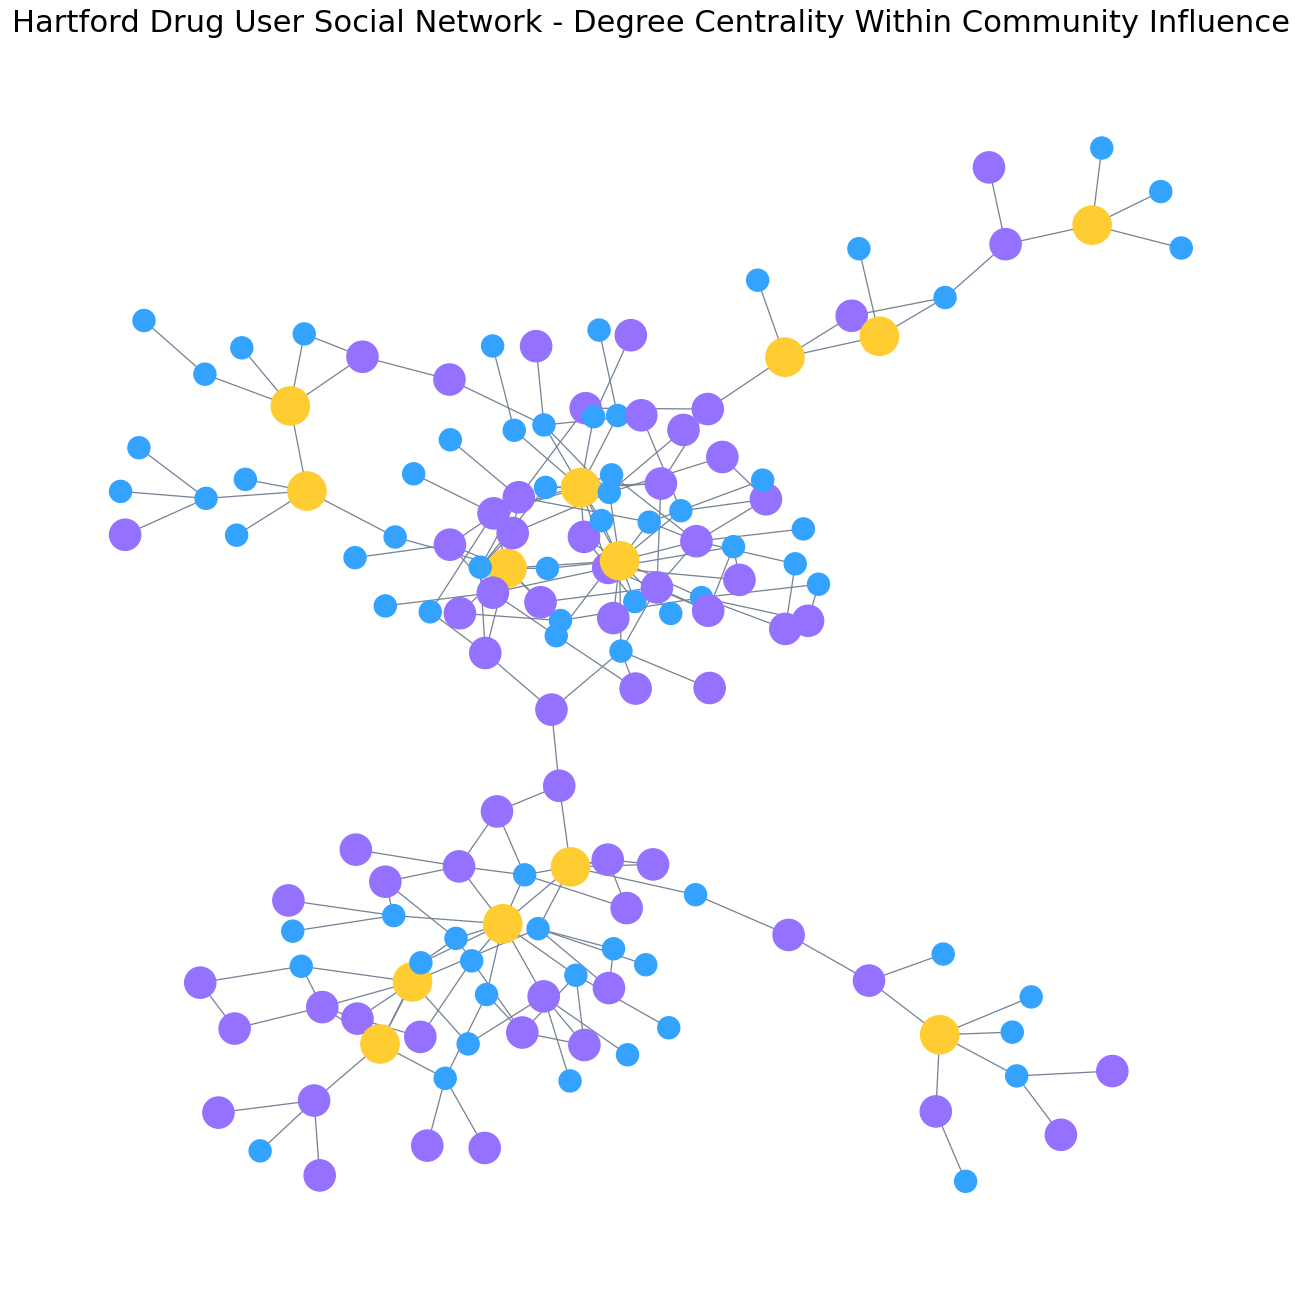

In [56]:
title = "Hartford Drug User Social Network - Degree Centrality Within Community Influence"


G2 = nx.from_pandas_edgelist(dfReachLinksB, source="FROM", target="TO", create_using=nx.Graph)

pos2 = nx.nx_pydot.graphviz_layout(G2, prog="neato")   # 'neato', ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’

df_reach_node_infoB1 = pd.DataFrame.from_dict(reach_network_catB, orient='index', columns=["category"])
df_reach_node_infoB1['size'] = np.where(df_reach_node_infoB1['category']==3, 900, 
                                        np.where(df_reach_node_infoB1['category']==2, 600,  
                                                          np.where(df_reach_node_infoB1['category']==1, 300, 50)
                                                         )
                                                )

df_reach_node_infoB1.reset_index(inplace=True)
df_reach_node_infoB1 = df_reach_node_infoB1.rename(columns = {'index':'node'})

df_reach_node_infoB1['label'] = np.where(df_reach_node_infoB1['category']>= 1, df_reach_node_infoB1['node'], '')

df_reach_node_infoB1.set_index('node', inplace=True)

# cmap = colors.ListedColormap([SAS_MAIN_HEX.colors[0], SAS_MAIN_HEX.colors[2], SAS_MAIN_HEX.colors[-2], SAS_MAIN_HEX.colors[-1]])

nx.set_node_attributes(G2, df_reach_node_infoB1.to_dict(orient='index'))
color_listB1 = list(nx.get_node_attributes(G2, 'category').values())
size_listB1 = list(nx.get_node_attributes(G2, 'size').values())
label_dictB1 = nx.get_node_attributes(G2, 'label')

plt.figure(figsize=(18,18), dpi=92)

plt.title(title, fontsize=24)

nx.draw(G2, 
        pos2, 
        node_size=size_listB1, 
        node_color=color_listB1, 
        cmap=SAS_MAIN_HEX, 
        edge_color=SAS_TEXT_HEX.colors[1], 
#        labels=label_dictB1, 
        font_color=SAS_TEXT_HEX.colors[-1],
        font_size=9
       )

sns.despine(left=True, bottom=True)
plt.show()

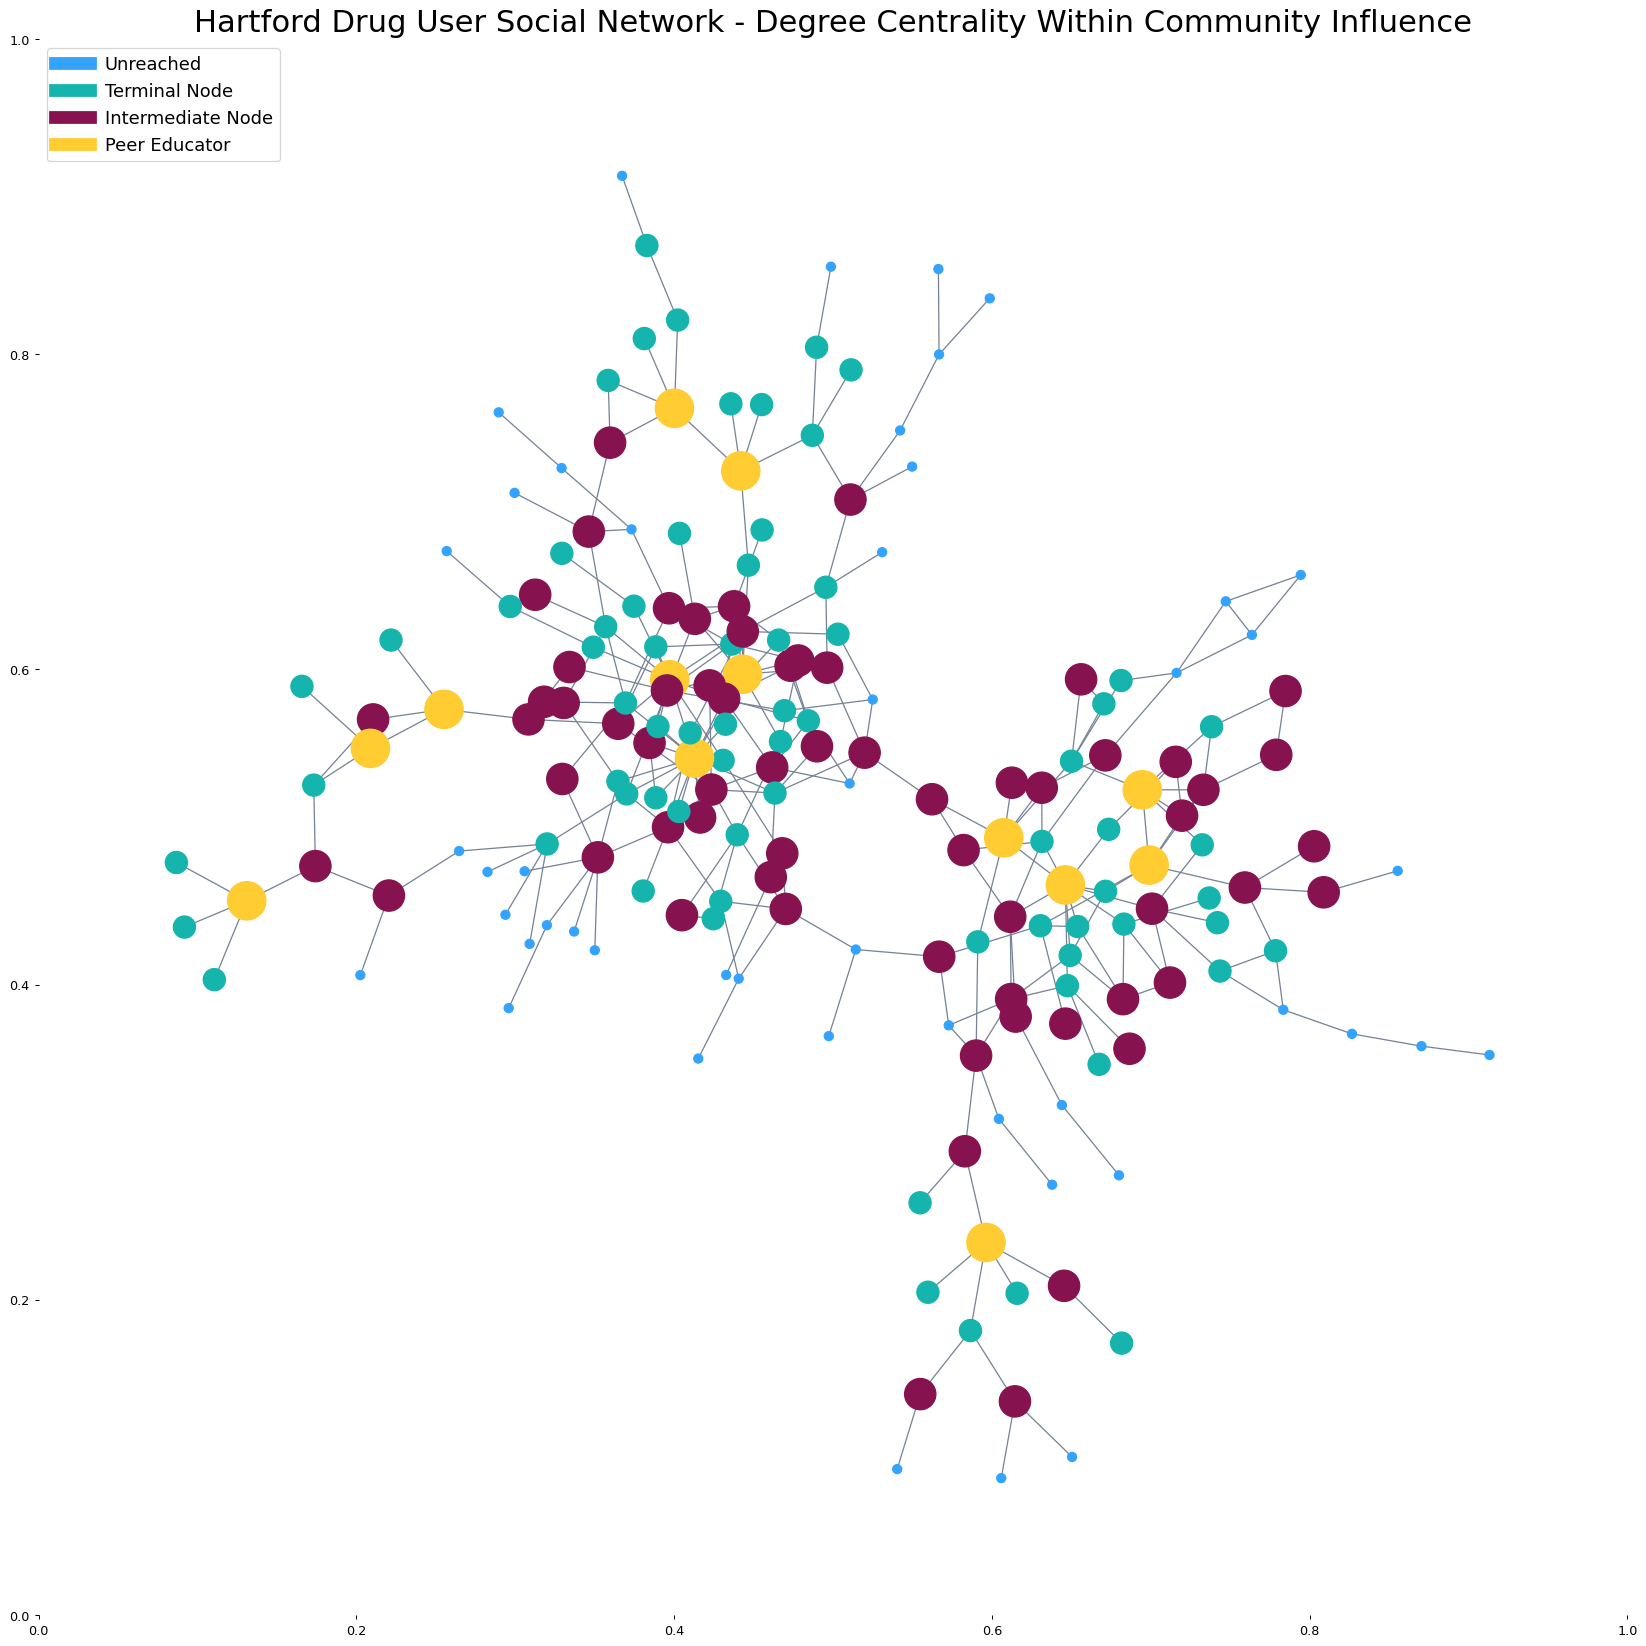

In [57]:
title = "Hartford Drug User Social Network - Degree Centrality Within Community Influence"

G_B = nx.from_pandas_edgelist(df_links, source="FROM", target="TO", create_using=nx.Graph)

df_node_infoB = pd.DataFrame.from_dict(full_network_catB, orient='index', columns=["category"])
df_node_infoB['size'] = np.where(df_node_infoB['category']==3, 900, np.where(df_node_infoB['category']==2, 600, np.where(df_node_infoB['category']== 1, 300, 50)))

df_node_infoB.reset_index(inplace=True)
df_node_infoB = df_node_infoB.rename(columns = {'index':'node'})

df_node_infoB['label'] = np.where(df_node_infoB['category']>= 1, df_node_infoB['node'], '')

df_node_infoB['title'] = np.where(df_node_infoB['category']==3, 'Peer Educator', 
                                          np.where(df_node_infoB['category']== 2, 'Intermediate Node', 
                                                   np.where(df_node_infoB['category']==1, 'Terminal Node', 
                                                            'Unreached'
                                                           )
                                                  )
                                         )

df_node_infoB.set_index('node', inplace=True)

nx.set_node_attributes(G_B, df_node_infoB.to_dict(orient='index'))
color_listB = list(nx.get_node_attributes(G_B, 'category').values())
size_listB = list(nx.get_node_attributes(G_B, 'size').values())
label_dictB = nx.get_node_attributes(G_B, 'label')
title_listB = list(nx.get_node_attributes(G_B, 'title').values())

plt.figure(figsize=(18,18), dpi=92)

plt.title(title, fontsize=24)

node_colorB = dict(zip(all_nodes, color_listB))
legend = list(set(color_listB))
title_dictB = dict(zip(color_listB, title_listB))

get_node_colorB = [node_colorB[v] for v in G_B]
cNormB = colors.Normalize(vmin=min(get_node_colorB), vmax=max(get_node_colorB))
scalarMapB = cmx.ScalarMappable(norm=cNormB, cmap=SAS_MAIN_HEX)

f = plt.figure(1)

ax = f.add_subplot(1,1,1)
for item in legend:
    ax.plot(
        [0],
        [0],
        color=scalarMapB.to_rgba(item),
        label=title_dictB[item],
        linewidth=10
    )
    

plt.legend(loc="upper left", prop={'size': 14})

nx.draw(G_B, 
        pos, 
        node_size=size_listB, 
        node_color=color_listB, 
        cmap=SAS_MAIN_HEX, 
        edge_color=SAS_TEXT_HEX.colors[1], 
#        labels=label_dictB, 
        font_color=SAS_TEXT_HEX.colors[-1],
        font_size=9
       )

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig(images_dir / 'method_b.png')
plt.show()

In [58]:
methodB_titleCounts = dict(Counter(title_listB))

resultsB = resultSummary(allNodes=len(all_nodes), 
                         educators=methodB_titleCounts['Peer Educator'], 
                         reached=len(all_nodes) - methodB_titleCounts['Peer Educator'] - methodB_titleCounts['Unreached'],
                         unreached=methodB_titleCounts['Unreached'],
                         educatorIDs=list(conn.CASTable('nodesubsetinB').to_dict()['node'].values())
                        )

In [59]:
resultsB

resultSummary(allNodes=193, educators=13, reached=133, unreached=47, educatorIDs=['69', '101', '130', '115', '34', '61', '77', '52', '43', '27', '2', '10', '4'])

## Method C: Influence Potential Based on Two-Hop Reach Networks

In [60]:
coverage = ceil(0.5 * conn.CASTable('outsummary')['Nodes'].tolist()[0])

print(f"50% coverage reaches {coverage} nodes.")

50% coverage reaches 97 nodes.


In [61]:
conn.network.reach(links         = "drug_network",
                   direction     = 'undirected',
                   eachsource    = True,
                   outReachNodes = {"name":"OptReachNodes",  "replace":True},
                   outReachLinks = {"name":"OptReachLinks",  "replace":True},
                   outCounts     = {"name":"OptReachCounts", "replace":True},
                   maxreach      = 2)

NOTE: The number of nodes in the input graph is 193.
NOTE: The number of links in the input graph is 273.
NOTE: Processing reach networks using 80 threads across 5 machines.
NOTE: Processing reach networks for 193 source networks.
NOTE: Processing reach networks used 0.00 (cpu: 0.00) seconds.


[OutputCasTables]

                 casLib            Name Label  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)   OptReachLinks        2650        3  CASTable('OptReachLinks', caslib='CASUSERHDFS(...
 1  CASUSERHDFS(daherr)   OptReachNodes        2209        2  CASTable('OptReachNodes', caslib='CASUSERHDFS(...
 2  CASUSERHDFS(daherr)  OptReachCounts         193        4  CASTable('OptReachCounts', caslib='CASUSERHDFS...

[ProblemSummary]

 Problem Summary
 
             Name1           Label1       cValue1  nValue1
 0        numNodes  Number of Nodes           193    193.0
 1        numLinks  Number of Links           273    273.0
 2  graphDirection  Graph Direction    Undirected      NaN

[SolutionSummary]

 Solution Summary
 
          Name1           Label1       cValue1   nValue1
 0  problemType     Problem Type         Reach       NaN
 1       status  Solution Status            OK       NaN
 2      cpuTime         CPU Time          0.00  0.000000
 3     realTime        Real Time          0.00  0.002323

[solutionStatus]

 'OK'

[solutionStatusCode]

 0

+ Elapsed: 0.0482s, user: 0.0662s, sys: 0.101s, mem: 555mb

In [62]:
conn.fetch('optreachnodes')

,reach,node
0,39.0,133
1,39.0,69
2,39.0,81
3,40.0,1
4,40.0,10
5,40.0,134
6,40.0,15
7,40.0,2
8,41.0,100
9,41.0,125


In [63]:
opt_code = f"""string      tmpLabel;
              set<num>    NODE_ID;
              set<string> NODE_LABEL init {{}};
              string      nodeIdToLabel{{NODE_ID}};
              num         nodeLabelToId{{NODE_LABEL}};

              set<num> REACH_SET{{NODE_ID}} init {{}}; 
              set<string,num> PAIRS;

              /* read data */
             read data NodesInitial into NODE_ID=[_n_] nodeIdToLabel=node;
             read data optReachNodes into PAIRS=[node reach];
             for{{i in NODE_ID}} do;
                tmpLabel   = nodeIdToLabel[i];
                NODE_LABEL = NODE_LABEL union {{tmpLabel}};
                nodeLabelToId[tmpLabel] = i;
             end;
             for{{<label,i> in PAIRS}} do;
                REACH_SET[i] = REACH_SET[i] union {{nodeLabelToId[label]}};
             end;

            /* declare decision variables */
            var x {{NODE_ID}} binary;

            /* declare objective */
            minimize numNodes = sum{{j in NODE_ID}} x[j];

            /* cover constraint */
            /*var IsCovered {{NODE_ID}} binary; */
            /*con cover {{i in NODE_ID}}: */
            /*  sum{{j in REACH_SET[i]}} x[j] >= IsCovered[i]; */
            /*con coverThreshold:
            /*  sum{{i in NODE_ID}} IsCovered[i] >= {coverage}; */
            
            con cover {{i in NODE_ID}}:
              sum{{j in REACH_SET[i]}} x[j] >= 1;

            /* solve */
            solve;

            create data Solution from [label]=
              (setof{{j in NODE_ID : round(x[j].sol)=1}}nodeIdToLabel[j]);"""

In [64]:
conn.optimization.runoptmodel(code=opt_code)

NOTE: There were 193 rows read from table 'NODESINITIAL' in caslib 'CASUSERHDFS(daherr)'.
NOTE: There were 2209 rows read from table 'OPTREACHNODES' in caslib 'CASUSERHDFS(daherr)'.
NOTE: Problem generation will use 16 threads.
NOTE: The problem has 193 variables (0 free, 0 fixed).
NOTE: The problem has 193 binary and 0 integer variables.
NOTE: The problem has 193 linear constraints (0 LE, 0 EQ, 193 GE, 0 range).
NOTE: The problem has 2209 linear constraint coefficients.
NOTE: The problem has 0 nonlinear constraints (0 LE, 0 EQ, 0 GE, 0 range).
NOTE: The OPTMODEL presolver is disabled for linear problems.
NOTE: The initial MILP heuristics are applied.
NOTE: The MILP presolver value AUTOMATIC is applied.
NOTE: The MILP presolver removed all variables and constraints.
NOTE: Optimal.
NOTE: Objective = 25.
NOTE: The output table 'SOLUTION' in caslib 'CASUSERHDFS(daherr)' has 25 rows and 1 columns.


[OutputCasTables]

                 casLib      Name Label  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  Solution          25        1  CASTable('Solution', caslib='CASUSERHDFS(daher...

[Solve1.ProblemSummary]

 Problem Summary
 
               Name1                   Label1       cValue1  nValue1
 0    objectiveSense          Objective Sense  Minimization      NaN
 1     objectiveName       Objective Function      numNodes      NaN
 2     objectiveType           Objective Type        Linear      NaN
 3                                                               NaN
 4           numVars      Number of Variables           193    193.0
 5   numBoundedAbove            Bounded Above             0      0.0
 6   numBoundedBelow            Bounded Below             0      0.0
 7        numBounded  Bounded Below and Above           193    193.0
 8           numFree                     Free             0      0.0
 9          numFixed                    Fixed             0      0.0
 10        numBinary                   Binary           193    193.0
 11       numInteger                  Integer             0      0.0
 12                                                              NaN
 13          numRows    Number of Constraints           193    193.0
 14            numLE           Linear LE (<=)             0      0.0
 15            numEQ            Linear EQ (=)             0      0.0
 16            numGE           Linear GE (>=)           193    193.0
 17         numRange             Linear Range             0      0.0
 18                                                              NaN
 19         numElems  Constraint Coefficients          2209   2209.0

[Solve1.SolutionSummary]

 Solution Summary
 
             Name1                 Label1         cValue1    nValue1
 0          solver                 Solver            MILP        NaN
 1       algorithm              Algorithm  Branch and Cut        NaN
 2   objectiveName     Objective Function        numNodes        NaN
 3       solStatus        Solution Status         Optimal        NaN
 4       objective        Objective Value              25  25.000000
 5                                                               NaN
 6       relObjGap           Relative Gap               0   0.000000
 7       absObjGap           Absolute Gap               0   0.000000
 8       primalInf   Primal Infeasibility               0   0.000000
 9        boundInf    Bound Infeasibility               0   0.000000
 10     integerInf  Integer Infeasibility               0   0.000000
 11                                                              NaN
 12      bestBound             Best Bound              25  25.000000
 13       numNodes                  Nodes               0   0.000000
 14   numSolutions        Solutions Found               3   3.000000
 15     iterations             Iterations               0   0.000000
 16   presolveTime          Presolve Time            0.00   0.001668
 17   solutionTime          Solution Time            0.00   0.003224

[absObjGap]

 0

[algorithm]

 'BAC'

[bestBound]

 25

[boundInf]

 0

[integerInf]

 0

[numIterations]

 0

[numNodes]

 0

[numSolutions]

 3

[objective]

 25

[presolveTime]

 0.00166797637939

[primalInf]

 0

[relObjGap]

 0

[solutionStatus]

 'OPTIMAL'

[solutionTime]

 0.00322389602661

[status]

 'OK'

+ Elapsed: 0.0601s, user: 0.0677s, sys: 0.0882s, mem: 97.3mb

In [65]:
conn.fetch("Solution")

,label
0,7
1,150
2,143
3,161
4,115
5,117
6,137
7,125
8,191
9,70


In [66]:
dfReachCountsC = pd.DataFrame(conn.CASTable('optreachcounts').to_frame())
dfReachLinksC = pd.DataFrame(conn.CASTable('optreachlinks').to_frame())

reach_setC = [float(x) for x in list(conn.CASTable('solution').to_dict()['label'].values())]

dfReachOnlyC = dfReachLinksC[dfReachLinksC['reach'].isin(reach_setC)]
                                                         
source_setC = dfReachCountsC[dfReachCountsC['reach'].isin(reach_setC)]['node'].to_list()

sink_set_C1 = [dfReachOnlyC[(dfReachOnlyC['reach'] == x) & (~dfReachOnlyC['TO'].isin(dfReachOnlyC[dfReachOnlyC['reach'] == x]['FROM']))]['TO'].to_list() for x in reach_setC]
sink_setC = list(set(list(itertools.chain(*sink_set_C1))))

included_nodesC = list(set(dfReachOnlyC['FROM'].to_list() + dfReachOnlyC['TO'].to_list()))

intermediate_nodesC = set(included_nodesC).difference(set(source_setC)).difference(set(sink_setC))

In [67]:
dfReachCountsC[dfReachCountsC['reach'].isin(reach_setC)]

,reach,node,count,count_not
14,53.0,146,16.0,177.0
15,54.0,147,8.0,185.0
16,55.0,148,9.0,184.0
20,59.0,151,3.0,190.0
29,68.0,16,13.0,180.0
30,69.0,160,7.0,186.0
31,70.0,161,15.0,178.0
37,76.0,167,10.0,183.0
53,92.0,181,6.0,187.0
59,98.0,187,3.0,190.0


In [68]:
source_nodes_dictC = {x:3 for x in source_setC}
inter_nodes_dictC = {x:2 for x in intermediate_nodesC}
terminal_nodes_dictC = {x: 1 for x in sink_setC}

reach_network_catC = {**terminal_nodes_dictC, **inter_nodes_dictC, **source_nodes_dictC}
reach_network_nodesC = list(reach_network_catC.keys())

all_nodes = list(G.nodes())
unreached_nodesC = list(set(all_nodes).difference(set(reach_network_nodesC)))
unreached_nodes_dictC = {x: 0 for x in unreached_nodesC}

full_network_catC = {**reach_network_catC, **unreached_nodes_dictC}

In [69]:
len(inter_nodes_dictC)

47

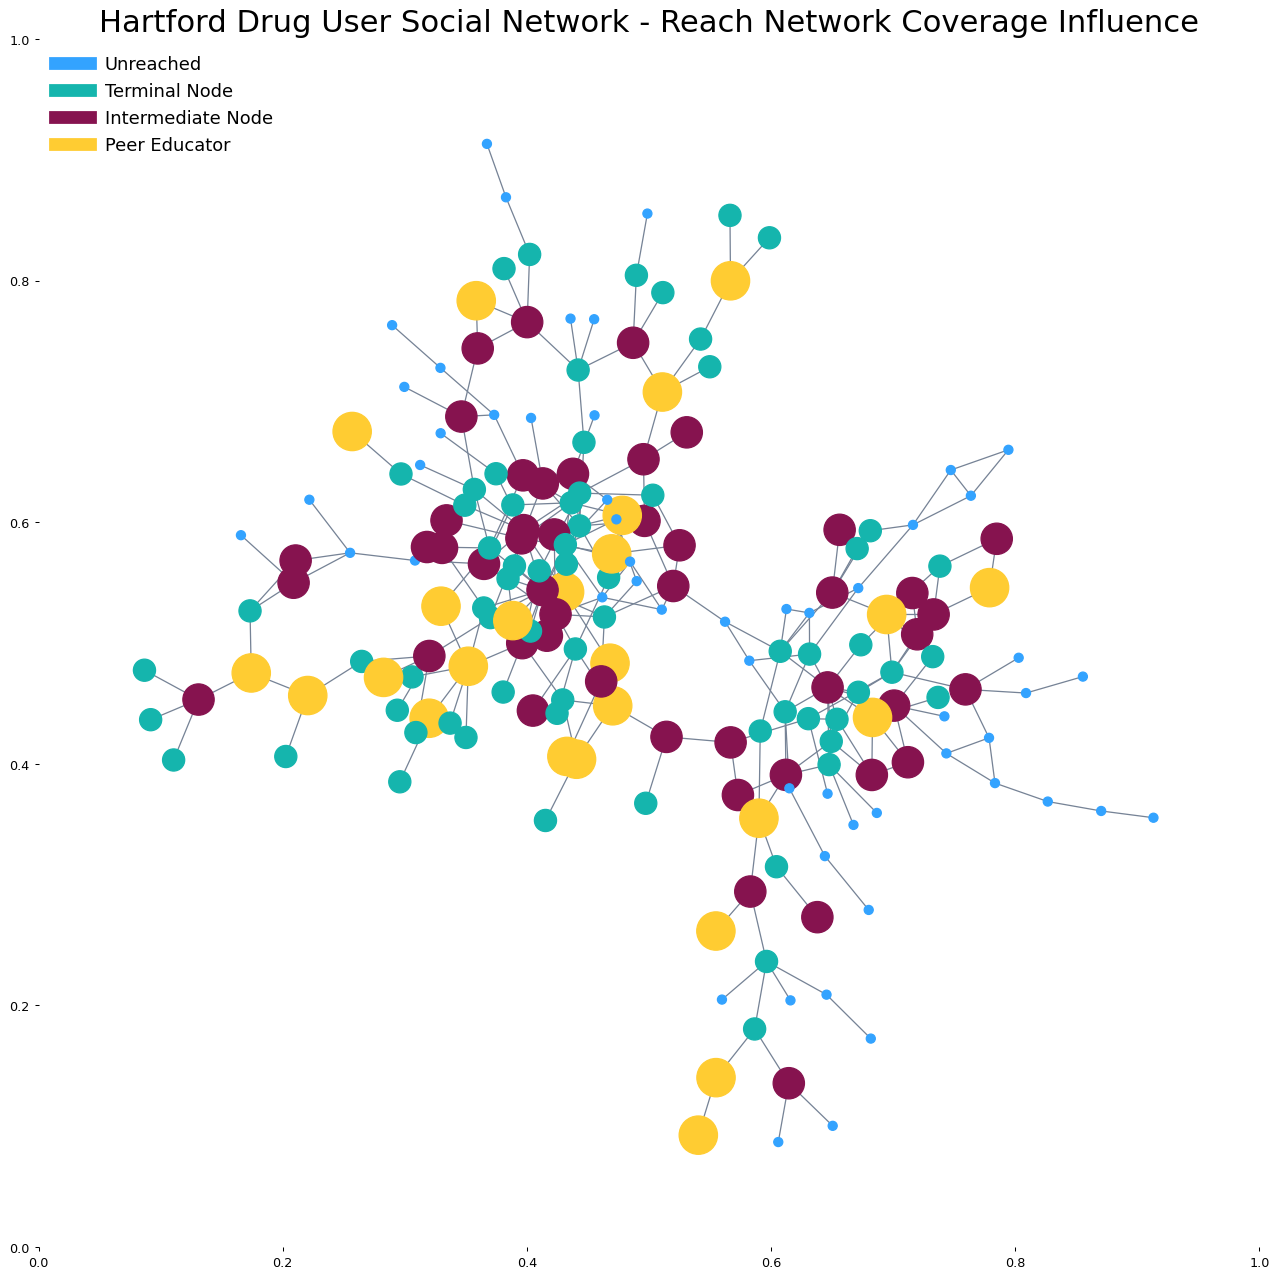

In [70]:
title = "Hartford Drug User Social Network - Reach Network Coverage Influence"

G_C = nx.from_pandas_edgelist(df_links, source="FROM", target="TO", create_using=nx.Graph)

df_node_infoC = pd.DataFrame.from_dict(full_network_catC, orient='index', columns=["category"])
df_node_infoC['size'] = np.where(df_node_infoC['category']==3, 900, np.where(df_node_infoC['category']==2, 600, np.where(df_node_infoC['category']==1, 300, 50)))

df_node_infoC.reset_index(inplace=True)
df_node_infoC = df_node_infoC.rename(columns = {'index':'node'})

df_node_infoC['label'] = np.where(df_node_infoC['category']>= 1, df_node_infoC['node'], '')

df_node_infoC['title'] = np.where(df_node_infoC['category']==3, 'Peer Educator', 
                                          np.where(df_node_infoC['category']== 2, 'Intermediate Node', 
                                                   np.where(df_node_infoC['category']==1, 'Terminal Node', 
                                                            'Unreached'
                                                           )
                                                  )
                                         )

df_node_infoC.set_index('node', inplace=True)

nx.set_node_attributes(G_C, df_node_infoC.to_dict(orient='index'))
color_listC = list(nx.get_node_attributes(G_C, 'category').values())
size_listC = list(nx.get_node_attributes(G_C, 'size').values())
label_dictC = nx.get_node_attributes(G_C, 'label')
title_listC = list(nx.get_node_attributes(G_C, 'title').values())

plt.figure(figsize=(14,14), dpi=92)

plt.title(title, fontsize=24)

node_colorC = dict(zip(all_nodes, color_listC))
legend = list(set(color_listC))
title_dictC = dict(zip(color_listC, title_listC))

get_node_colorC = [node_colorC[v] for v in G_C]
cNormC = colors.Normalize(vmin=min(get_node_colorC), vmax=max(get_node_colorC))
scalarMapC = cmx.ScalarMappable(norm=cNormC, cmap=SAS_MAIN_HEX)

f = plt.figure(1)
ax = f.add_subplot(1,1,1)
    
for item in legend:
    ax.plot(
        [0],
        [0],
        color=scalarMapC.to_rgba(item),
        label=title_dictC[item],
        linewidth=10,
    )
    

nx.draw(G_C, 
        pos, 
        node_size=size_listC, 
        node_color=color_listC, 
        cmap=SAS_MAIN_HEX, 
        edge_color=SAS_TEXT_HEX.colors[1], 
       )

plt.legend(loc="upper left", prop={'size': 14}, frameon=False)
plt.tight_layout()

sns.despine(left=True, bottom=True)
plt.savefig(images_dir / 'method_c.png')
plt.show()

In [71]:
methodC_titleCounts = dict(Counter(title_listC))

resultsC = resultSummary(allNodes=len(all_nodes), 
                         educators=methodC_titleCounts['Peer Educator'], 
                         reached=len(all_nodes) - methodC_titleCounts['Peer Educator'] - methodC_titleCounts['Unreached'],
                         unreached=methodC_titleCounts['Unreached'],
                         educatorIDs=source_setC)

In [72]:
dfFullResults = pd.DataFrame([resultsA, resultsB, resultsC], index=['Method A', 'Method B', 'Method C'])

In [73]:
dfFullResults

,allNodes,educators,reached,unreached,educatorIDs
Method A,193,19,132,42,"[113, 115, 17, 19, 21, 27, 28, 33, 34, 42, 43,..."
Method B,193,13,133,47,"[69, 101, 130, 115, 34, 61, 77, 52, 43, 27, 2,..."
Method C,193,25,114,54,"[146, 147, 148, 151, 16, 160, 161, 167, 181, 1..."


In [74]:
set(dfFullResults.loc['Method A']['educatorIDs']).intersection(set(dfFullResults.loc['Method B']['educatorIDs'])).intersection(set(dfFullResults.loc['Method C']['educatorIDs']))

{'115'}

In [75]:
set(dfFullResults.loc['Method A']['educatorIDs']).intersection(set(dfFullResults.loc['Method B']['educatorIDs']))

{'115', '27', '34', '43', '61', '69', '77'}

In [76]:
set(dfFullResults.loc['Method A']['educatorIDs']).intersection(set(dfFullResults.loc['Method C']['educatorIDs']))

{'115', '28', '53'}

In [77]:
set(dfFullResults.loc['Method B']['educatorIDs']).intersection(set(dfFullResults.loc['Method C']['educatorIDs']))

{'115'}

### Conclusion

Using network analytics, we were able to use a simple edge list to identify specific nodes that would be good targets for intervention to help deter social drug use and needle sharing.

The list of targeted nodes is highlighted in the plot above and in the table below.

Wrap everything up by terminating the session.

In [78]:
conn.terminate()